In [49]:
import torch
import numpy as np
import pandas as pd
import pickle
import statistics
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import significantdigits as sd
import re
import json
from matplotlib.lines import Line2D
import nibabel as nib
from nilearn import plotting
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go


## Random

In [3]:
a = []
for i in range(1,6):
    a.append( nib.load(f'/home/inesgp/verrou_fastsurfer/debug/0003002_{i}/mri/aparc.DKTatlas+aseg.deep.mgz').get_fdata() )

In [5]:
a = np.array(a)

<Axes: >

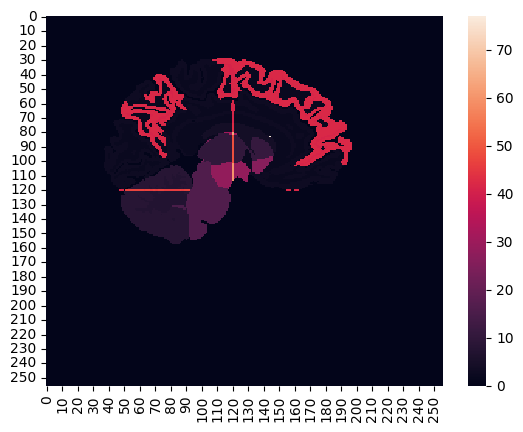

In [14]:
sub = nib.load('/home/inesgp/verrou_fastsurfer/sub-0003002/0003002_1_sr/mri/aseg.auto_noCCseg.mgz').get_fdata()
sns.heatmap(sub[120])

In [10]:
for i in a:
    print(np.unique(i))

[0.]
[0.]
[0.]
[0.]
[0.]


<Axes: >

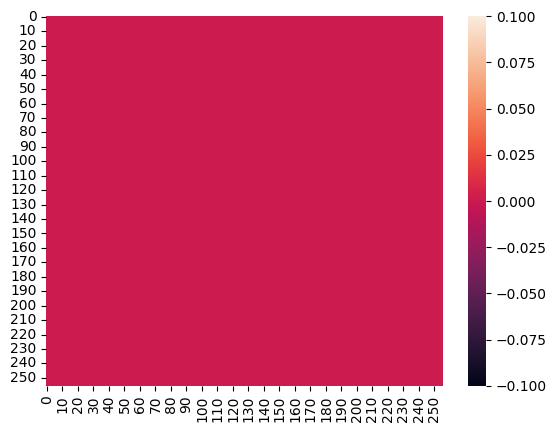

In [8]:
sns.heatmap(a.std(axis=0)[:,120])

## TO DO

* Clean up  notebook later

## Runtime

In [ ]:
# FastSurfer

fuzzy_singlethread_fastsurfer = []
verrou_fastsurfer = []
default_fastsurfer = []

for iter in range(2,6):
    f = open(f"/home/inesgp/verrou_fastsurfer/slurm/fuzzy_fastsurfer_{iter}.out")
    time_per_sub = []
    for line in f: 
        if "real" in line:
            time_str = line.split('real')[-1]
            minutes, seconds = time_str.split('m')
            seconds = float(seconds.replace('s', ''))
            total_seconds = int(minutes) * 60 + seconds
            time_per_sub.append(total_seconds)
    fuzzy_singlethread_fastsurfer.append(time_per_sub)

fuzzy_singlethread_fastsurfer = np.array(fuzzy_singlethread_fastsurfer).mean(axis=1)

for iter in range(2,6):
    f = open(f"/home/inesgp/verrou_fastsurfer/slurm/ieee_fastsurfer_{iter}.out")
    time_per_sub = []
    for line in f: 
        if "real" in line:
            time_str = line.split('real')[-1]
            minutes, seconds = time_str.split('m')
            seconds = float(seconds.replace('s', ''))
            total_seconds = int(minutes) * 60 + seconds
            time_per_sub.append(total_seconds)
    default_fastsurfer.append(time_per_sub)

default_fastsurfer = np.array(default_fastsurfer).mean(axis=1)


for iter in range(2,6):
    time_per_sub = []
    for sub in range(1,6):
        f = open(f"/home/inesgp/verrou_fastsurfer/runtime/{iter}_{sub}.log")
        for line in f: 
            if "elapsed" in line:
                time_str = re.search(r'(\d+):(\d+):(\d+)', line)
                # if time_match:
                hours, minutes, seconds = map(int, time_str.groups())
                total_seconds = hours * 3600 + minutes * 60 + seconds
                time_per_sub.append(total_seconds)

    verrou_fastsurfer.append(time_per_sub)

verrou_fastsurfer = np.array(verrou_fastsurfer).mean(axis=1)


# verrou_ratio = [(v/f) for v,f in zip(verrou_fastsurfer, fuzzy_fastsurfer)]
verrou_singlethread_ratio = [(v/f) for v,f in zip(verrou_fastsurfer, fuzzy_singlethread_fastsurfer)]
# fuzzy_ratio = [(d/f) for f,d in zip(fuzzy_rr_mnist, default_mnist)]

# fastsurfer_runtime = pd.DataFrame({'Default': default_fastsurfer,'Verrou': verrou_fastsurfer, 'Fuzzy PyTorch': fuzzy_fastsurfer, 'Fuzzy PyTorch Single Threaded': fuzzy_singlethread_fastsurfer, 
#                               "Fuzzy Speed Up Factor from Verrou": verrou_ratio, "Fuzzy Single Threaded Speed Up Factor from Verrou": verrou_singlethread_ratio, })

fastsurfer_runtime = pd.DataFrame({'Default': default_fastsurfer, 'Verrou': verrou_fastsurfer, 'Fuzzy PyTorch Single Threaded': fuzzy_singlethread_fastsurfer, 
                              "Fuzzy Single Threaded Speed Up Factor from Verrou": verrou_singlethread_ratio, })

fastsurfer_runtime = fastsurfer_runtime.rename(index={0: 'MCA Iteration 1', 1: 'MCA Iteration 2', 2: 'MCA Iteration 3', 3: 'MCA Iteration 4', })

fastsurfer_runtime

,Default,Verrou,Fuzzy PyTorch Single Threaded,Fuzzy Single Threaded Speed Up Factor from Verrou
MCA Iteration 1,8520.5546,1758322.6,44907.5632,39.154264
MCA Iteration 2,8739.0932,1757598.2,44996.0380,39.061177
MCA Iteration 3,15595.7988,1758237.8,50443.6954,34.855452
MCA Iteration 4,5655.2488,1758062.2,24666.6974,71.272703


In [44]:
# MNIST

# fuzzy_mnist = [] # fuzzy UD multithread
fuzzy_singlethread_ud_mnist = []
fuzzy_singlethread_sr_mnist = []
verrou_ud_mnist = []
verrou_sr_mnist = []
default_mnist = []

for num in range(1,6):
    # f = open(f"/home/inesgp/mnist/slurm/fuzzy_mnist_test_{num}.out")
    # for line in f: 
    #     if "real" in line:
    #         time_str = line.split('real')[-1]
    #         minutes, seconds = time_str.split('m')
    #         seconds = float(seconds.replace('s', ''))
    #         total_seconds = int(minutes) * 60 + seconds
    #         fuzzy_mnist.append(total_seconds)

    f = open(f"/home/inesgp/mnist/slurm/fuzzy_mnist_test_singlethread_{num}.out")
    for line in f: 
        if "real" in line:
            time_str = line.split('real')[-1]
            minutes, seconds = time_str.split('m')
            seconds = float(seconds.replace('s', ''))
            total_seconds = int(minutes) * 60 + seconds
            fuzzy_singlethread_ud_mnist.append(total_seconds)
    
    f = open(f"/home/inesgp/mnist/slurm/fuzzy_mnist_test_v2_{num}.out")
    for line in f: 
        if "real" in line:
            time_str = line.split('real')[-1]
            minutes, seconds = time_str.split('m')
            seconds = float(seconds.replace('s', ''))
            total_seconds = int(minutes) * 60 + seconds
            fuzzy_singlethread_sr_mnist.append(total_seconds)

    f = open(f"/home/inesgp/mnist/slurm/verrou_ud_trace_mnist_test_{num}.out")
    for line in f: 
        if "real" in line:
            time_str = line.split('real')[-1]
            minutes, seconds = time_str.split('m')
            seconds = float(seconds.replace('s', ''))
            total_seconds = int(minutes) * 60 + seconds
            verrou_ud_mnist.append(total_seconds)

    f = open(f"/home/inesgp/mnist/slurm/verrou_sr_trace_mnist_test_{num}.out")
    for line in f: 
        if "real" in line:
            time_str = line.split('real')[-1]
            minutes, seconds = time_str.split('m')
            seconds = float(seconds.replace('s', ''))
            total_seconds = int(minutes) * 60 + seconds
            verrou_sr_mnist.append(total_seconds)


    f = open(f"/home/inesgp/mnist/slurm/default_mnist_test_{num}.out")
    for line in f: 
        if "real" in line:
            time_str = line.split('real')[-1]
            minutes, seconds = time_str.split('m')
            seconds = float(seconds.replace('s', ''))
            total_seconds = int(minutes) * 60 + seconds
            default_mnist.append(total_seconds)

verrou_ud_ratio_singlethread = [(v/f) for v,f in zip(verrou_ud_mnist, fuzzy_singlethread_ud_mnist)]
verrou_sr_ratio_singlethread = [(v/f) for v,f in zip(verrou_sr_mnist, fuzzy_singlethread_sr_mnist)]
# fuzzy_ratio = [(d/f) for f,d in zip(fuzzy_rr_mnist, default_mnist)]

mnist_runtime = pd.DataFrame({'Default': default_mnist,'Verrou UD': verrou_ud_mnist, 'Verrou SR': verrou_sr_mnist, 'Fuzzy UD PyTorch': fuzzy_singlethread_ud_mnist, 'Fuzzy SR PyTorch': fuzzy_singlethread_sr_mnist, 
                              "Fuzzy UD Speed Up Factor from Verrou": verrou_ud_ratio_singlethread, "Fuzzy SR Speed Up Factor from Verrou": verrou_sr_ratio_singlethread, })
mnist_runtime = mnist_runtime.rename(index={0: 'MCA Iteration 1', 1: 'MCA Iteration 2', 2: 'MCA Iteration 3', 3: 'MCA Iteration 4', 4: 'MCA Iteration 5'})

print('Only observing single threaded results')
# print('Average Speed Up Factor: ',mnist_runtime['Speed Up Factor'].mean())
mnist_runtime

Only observing single threaded results


,Default,Verrou UD,Verrou SR,Fuzzy UD PyTorch,Fuzzy SR PyTorch,Fuzzy UD Speed Up Factor from Verrou,Fuzzy SR Speed Up Factor from Verrou
MCA Iteration 1,14.004,4722.666,4801.143,198.860,5154.173,23.748698,0.931506
MCA Iteration 2,14.016,4278.724,4817.184,196.761,5130.386,21.745793,0.938952
MCA Iteration 3,14.013,4276.504,4813.450,200.517,5119.222,21.327389,0.940270
MCA Iteration 4,14.008,4258.391,4960.544,199.072,5217.241,21.391210,0.950798
MCA Iteration 5,13.999,4267.812,4095.451,199.142,5131.316,21.430999,0.798129


## MNIST Variability

**MCA -- 10 Iterations**

**TO DO**
* Fix fuzzy multithread

### Metric Analysis

In [2]:
from significantdigits import Error

def compile_results(dir_name, ):
    pred = {}
    target = {} 
    output = {}
    loss = {}
    for num in range(1,6):
    
        res = pickle.load(open(f'{dir_name}/test_metrics_{num}.pkl', 'rb'))
        # res = pickle.load(open('mnist_results_full/mnist_results_1.pkl', 'rb'))
    
        tmp_pred = torch.tensor([])
        tmp_target = torch.tensor([])
        tmp_output = torch.tensor([])
        tmp_loss = []
        
        for i in res.keys():
            for k in res[i]:
                # print(k)
                if i == 'pred': tmp_pred = torch.cat((tmp_pred, k))
                elif i == 'target': tmp_target = torch.cat((tmp_target, k))
                elif i == 'output': tmp_output = torch.cat((tmp_output, k))
                elif i == 'loss': tmp_loss.append(k)
    
        # print(tmp_output.shape)
        pred[num] = tmp_pred.numpy() 
        target[num] = tmp_target.numpy() 
        output[num] = tmp_output.numpy() 
        loss[num] = tmp_loss

    return pred, target, output, loss

def metric_unstability(pred, target, loss):

    #gotten from slurm output
    #TODO save to file
    # avg_loss = [0.025298748701810838, 0.025298750564455987, 0.025298746135830878, 0.02529873021543026, 0.025298738285899163, 
    #         0.025298739501833915, 0.02529874346256256, 0.02529875337779522, 0.025298740258812905, 0.0252987517952919]

    acc = []
    macro_f1 = []
    weighted_f1 = []
    macro_precision = []
    weighted_precision = []
    macro_recall = []
    weighted_recall = []
    
    for i, j in zip(target, pred):
        acc.append(accuracy_score(target[i], pred[j]))
        macro_f1.append(f1_score(target[i], pred[j], average='macro'))
        weighted_f1.append(f1_score(target[i], pred[j], average='weighted'))
        macro_precision.append(precision_score(target[i], pred[j], average='macro'))
        weighted_precision.append(precision_score(target[i], pred[j], average='weighted'))
        macro_recall.append(recall_score(target[i], pred[j], average='macro'))
        weighted_recall.append(recall_score(target[i], pred[j], average='weighted'))
    
    # results = {'Accuracy': acc, 'Macro F1': macro_f1, 'Macro Precision': macro_precision, 'Macro Recall': macro_recall, 
    #            'Average Loss': avg_loss}
    
    results = {'Accuracy': acc, 'Macro F1': macro_f1, 'Weighted F1': weighted_f1, 'Macro Precision': macro_precision, 
               'Weighted Precision': weighted_precision, 'Macro Recall': macro_recall, 'Weighted Recall': weighted_recall, 
               'Average Loss per Batch': loss}
    metrics = {}
    for m in results:
        if 'Average Loss per Batch' == m:
            metrics[m] = {'Mean': [np.mean(np.mean(np.array(list(loss.values())),axis=0))], 
                          'Standard Deviation': [np.mean(np.std(np.array(list(loss.values())),axis=0))],
                          'Significant Digits': [ np.mean( sd.significant_digits(np.array(list(loss.values()), dtype=np.float32), reference=np.mean(np.array(list(loss.values())), axis=0, dtype=np.float32),  basis=10, error=Error.Relative) ) ]  }
        else: metrics[m] = {'Mean': [statistics.mean(results[m])], 'Standard Deviation': [statistics.stdev(results[m])], 'Significant Digits': [sd.significant_digits(np.array(results[m], dtype=np.float32), reference=np.mean(results[m], dtype=np.float32),  basis=10, error=Error.Relative)] }



    df = pd.concat( [pd.DataFrame(metrics['Accuracy']), pd.DataFrame(metrics['Macro F1']), pd.DataFrame(metrics['Weighted F1']),
                pd.DataFrame(metrics['Macro Precision']), pd.DataFrame(metrics['Weighted Precision']),
                pd.DataFrame(metrics['Macro Recall']), pd.DataFrame(metrics['Weighted Recall']), 
                     pd.DataFrame(metrics['Average Loss per Batch'])] )
    
    df.index = ['Accuracy', 'Macro F1', 'Weighted F1', 'Macro Precision', 'Weighted Precision', 'Macro Recall', 'Weighted Recall',
                'Average Loss per Batch'] 
    
    # df.loc[df.index != "Average Loss per Batch", "Mean"] *= 100

    
    return df


In [3]:
default_pred, default_target, default_output, default_loss = compile_results('/home/inesgp/mnist/default', )
# fuzzy_pred, fuzzy_target, fuzzy_output, fuzzy_loss = compile_results('/home/inesgp/mnist/fuzzy', )
fuzzy_ud_singlethread_pred, fuzzy_ud_singlethread_target, fuzzy_ud_singlethread_output, fuzzy_ud_singlethread_loss = compile_results('/home/inesgp/mnist/fuzzy_singlethread', )
fuzzy_sr_singlethread_pred, fuzzy_sr_singlethread_target, fuzzy_sr_singlethread_output, fuzzy_sr_singlethread_loss = compile_results('/home/inesgp/mnist/fuzzy_v2', )
verrou_ud_pred, verrou_ud_target, verrou_ud_output, verrou_ud_loss = compile_results('/home/inesgp/mnist/verrou_ud_trace', )
verrou_sr_pred, verrou_sr_target, verrou_sr_output, verrou_sr_loss = compile_results('/home/inesgp/mnist/verrou_sr_trace', )


# fuzzy_df = metric_unstability(fuzzy_pred, fuzzy_target, fuzzy_loss)
fuzzy_ud_singlethread_df = metric_unstability(fuzzy_ud_singlethread_pred, fuzzy_ud_singlethread_target, fuzzy_ud_singlethread_loss)
fuzzy_sr_singlethread_df = metric_unstability(fuzzy_sr_singlethread_pred, fuzzy_sr_singlethread_target, fuzzy_sr_singlethread_loss)
verrou_ud_df = metric_unstability(verrou_ud_pred, verrou_ud_target, verrou_ud_loss)
verrou_sr_df = metric_unstability(verrou_sr_pred, verrou_sr_target, verrou_sr_loss)
default_df = metric_unstability(default_pred, default_target, default_loss)

In [ ]:
# fig, ax = plt.subplots()

# # ax.plot(np.arange(len(fuzzy_df['Mean'])), fuzzy_df['Significant Digits'],  marker='o', label='Fuzzy Multi Threaded')
# ax.plot(np.arange(len(fuzzy_ud_singlethread_df['Mean'])), fuzzy_ud_singlethread_df['Significant Digits'],  marker='o', label='Fuzzy UD Single Threaded')
# ax.plot(np.arange(len(fuzzy_sr_singlethread_df['Mean'])), fuzzy_sr_singlethread_df['Significant Digits'],  marker='o', label='Fuzzy SR Single Threaded')
# ax.plot(np.arange(len(verrou_ud_df['Mean'])), verrou_ud_df['Significant Digits'],  marker='o', label='Verrou UD')
# ax.plot(np.arange(len(verrou_sr_df['Mean'])), verrou_sr_df['Significant Digits'],  marker='o', label='Verrou SR')
# ax.plot(np.arange(len(default_df['Mean'])), default_df['Significant Digits'],  marker='o', label='IEEE')
# ax.set_xticklabels([item for item in [''] + list(default_df.index)], rotation=30)
# ax.set_xlabel('Metrics', fontsize=13), ax.set_ylabel('Significant Sigits', fontsize=13)
# ax.set_ylim(5.,7)
# ax.legend()
# plt.savefig(f'/home/inesgp/mnist/mnist_sig_metrics.pdf', bbox_inches='tight');

fig = go.Figure()

# Add traces for each data series
fig.add_trace(go.Scatter(
    x=np.arange(len(fuzzy_ud_singlethread_df['Mean'])),
    y=fuzzy_ud_singlethread_df['Significant Digits'],
    mode='lines+markers',
    name='Fuzzy UD'
))

fig.add_trace(go.Scatter(
    x=np.arange(len(fuzzy_sr_singlethread_df['Mean'])),
    y=fuzzy_sr_singlethread_df['Significant Digits'],
    mode='lines+markers',
    name='Fuzzy SR'
))

fig.add_trace(go.Scatter(
    x=np.arange(len(verrou_ud_df['Mean'])),
    y=verrou_ud_df['Significant Digits'],
    mode='lines+markers',
    name='Verrou UD'
))

fig.add_trace(go.Scatter(
    x=np.arange(len(verrou_sr_df['Mean'])),
    y=verrou_sr_df['Significant Digits'],
    mode='lines+markers',
    name='Verrou SR'
))

fig.add_trace(go.Scatter(
    x=np.arange(len(default_df['Mean'])),
    y=default_df['Significant Digits'],
    mode='lines+markers',
    name='IEEE'
))

# Set axis labels
fig.update_layout(
    width=800,
    height=500,
    margin=dict(l=10, r=10, t=30, b=10),  # Tight margins
    xaxis=dict(
        title='Metrics',
        tickmode='array',
        tickvals=np.arange(len(default_df.index)),
        ticktext=list(default_df.index),
        tickangle=20
    ),
    yaxis=dict(
        title='Significant Digits',
        range=[5.0, 7.0]
    ),
    legend=dict(
        orientation='h',  
        yanchor='bottom',  
        xanchor='center',  
        y=1.0,             # Position the legend above the plot (slightly above the top y-axis)
        x=0.5              # Center the legend horizontally
    ),
    font=dict(size=13),
    # template="plotly_white"
)

# Save as PDF (requires Kaleido for offline export)
fig.write_image('/home/inesgp/mnist/mnist_sig_metrics.pdf', engine="kaleido", format='pdf')

# Show the figure
fig.show()


### Embeddings

/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)


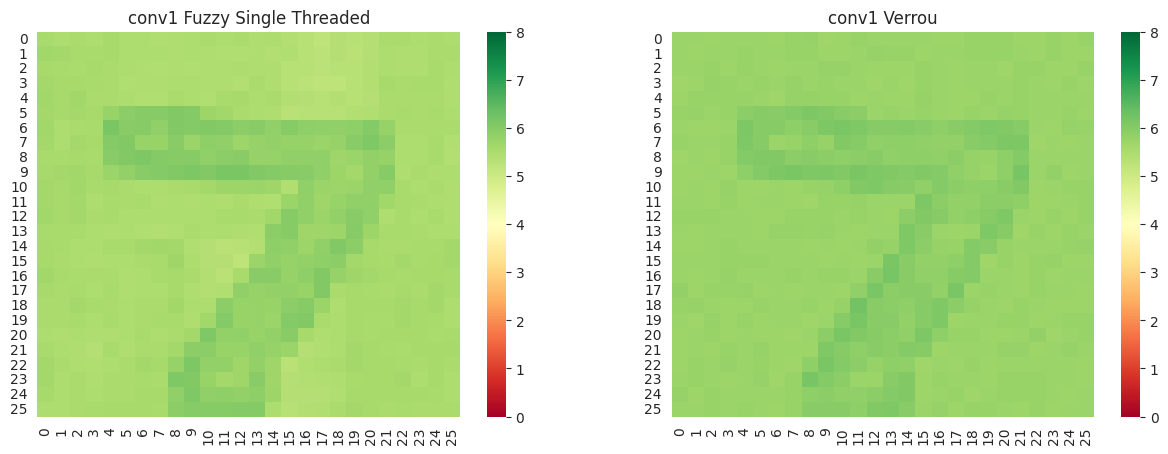

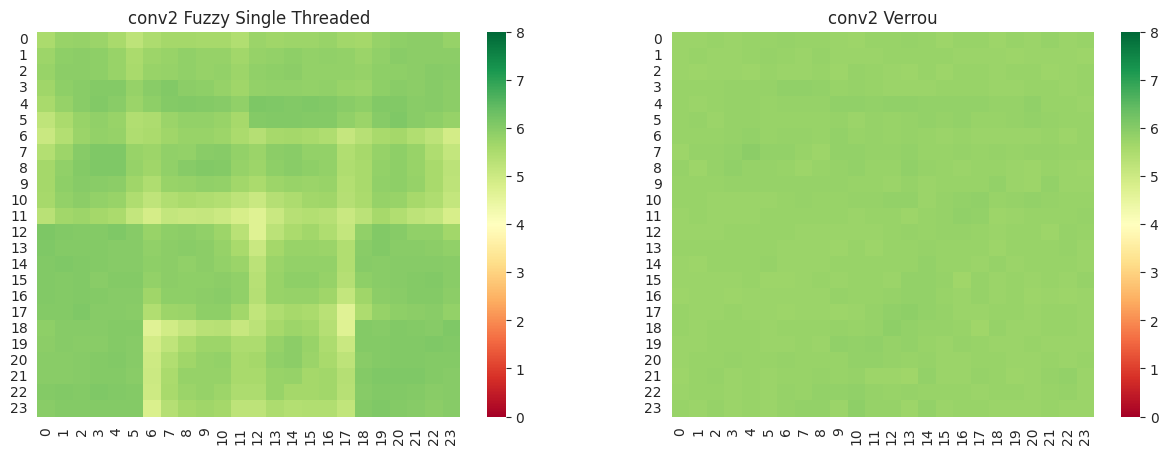

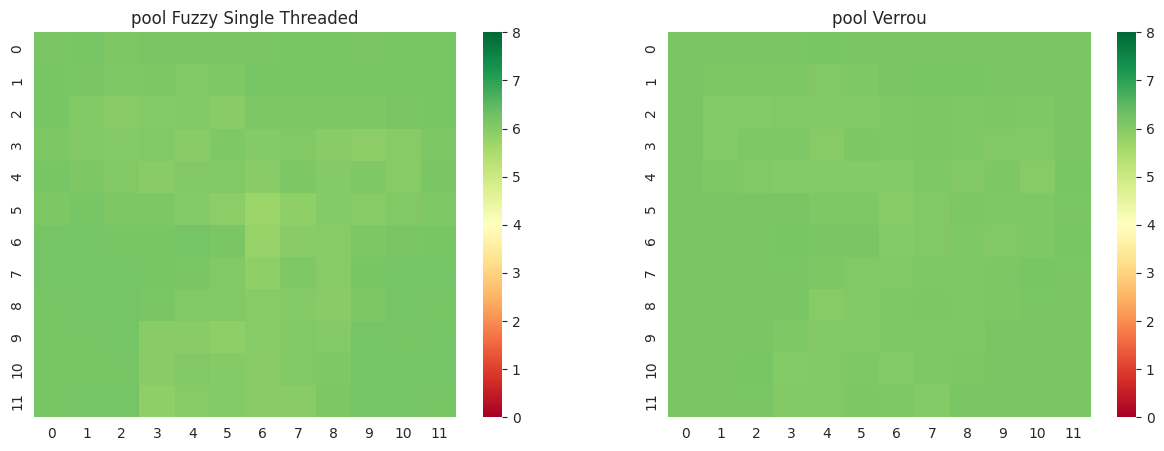

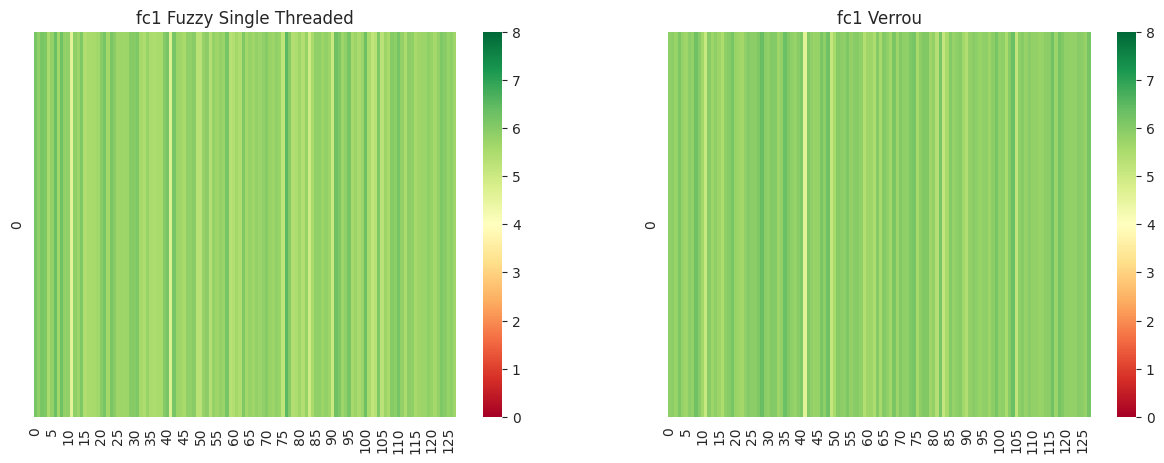

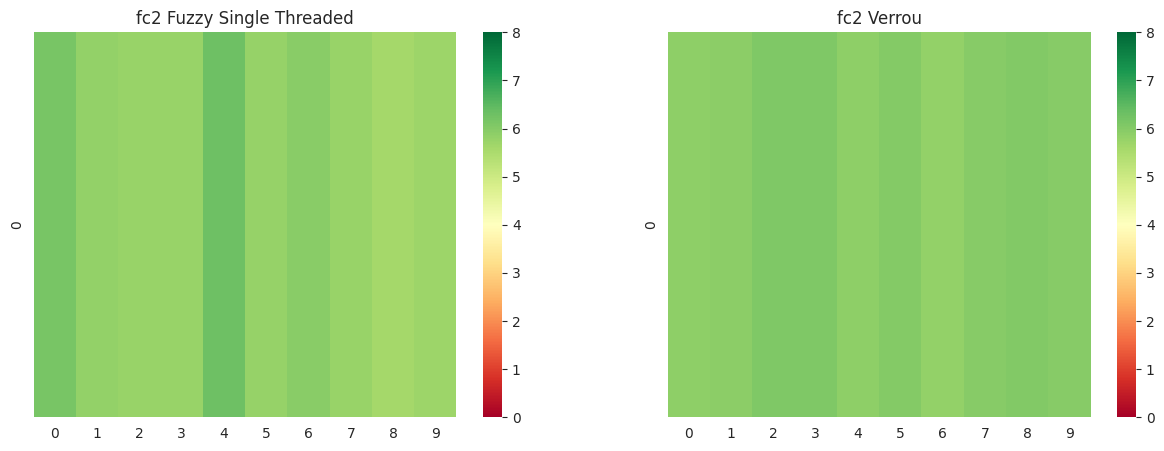

In [107]:
for layer in ['conv1', 'conv2', 'pool', 'fc1', 'fc2']:

    embed_fuzzy_singlethread = []
    embed_verrou = []
    for i in range(1,6):
        embed_fuzzy_singlethread.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/fuzzy_singlethread/{layer}_{i}.pkl", 'rb')) )
        embed_verrou.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/verrou/{layer}_{i}.pkl", 'rb')) )
    embed_fuzzy_singlethread = torch.stack(embed_fuzzy_singlethread)
    embed_verrou = torch.stack(embed_verrou)

    fig, axes = plt.subplots(1,2, figsize=(15,5))

    if 'fc' in layer: 
        #fuzzy single threaded
        layer_sig = sd.significant_digits(embed_fuzzy_singlethread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_singlethread, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(np.expand_dims(layer_sig[0], axis=0), ax=axes[0], cmap='RdYlGn', vmin=0, vmax=8)
        #verrou
        layer_sig = sd.significant_digits(embed_verrou.type(dtype=torch.float32), reference=torch.mean(embed_verrou, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(np.expand_dims(layer_sig[0], axis=0), ax=axes[1], cmap='RdYlGn', vmin=0, vmax=8)
    
    else:
        #fuzzy single threaded
        layer_sig = sd.significant_digits(embed_fuzzy_singlethread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_singlethread, dim=0, dtype=torch.float32),  basis=10)[0]
        sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float32), ax=axes[0], cmap='RdYlGn', vmin=0, vmax=8)
        #verrou
        layer_sig = sd.significant_digits(embed_verrou.type(dtype=torch.float32), reference=torch.mean(embed_verrou, dim=0, dtype=torch.float32),  basis=10)[0]
        sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float32), ax=axes[1], cmap='RdYlGn', vmin=0, vmax=8)
        
    axes[0].set_title(f"{layer} Fuzzy Single Threaded")
    axes[1].set_title(f"{layer} Verrou")
    # break

plt.show()

#### Single Data Sample

/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)


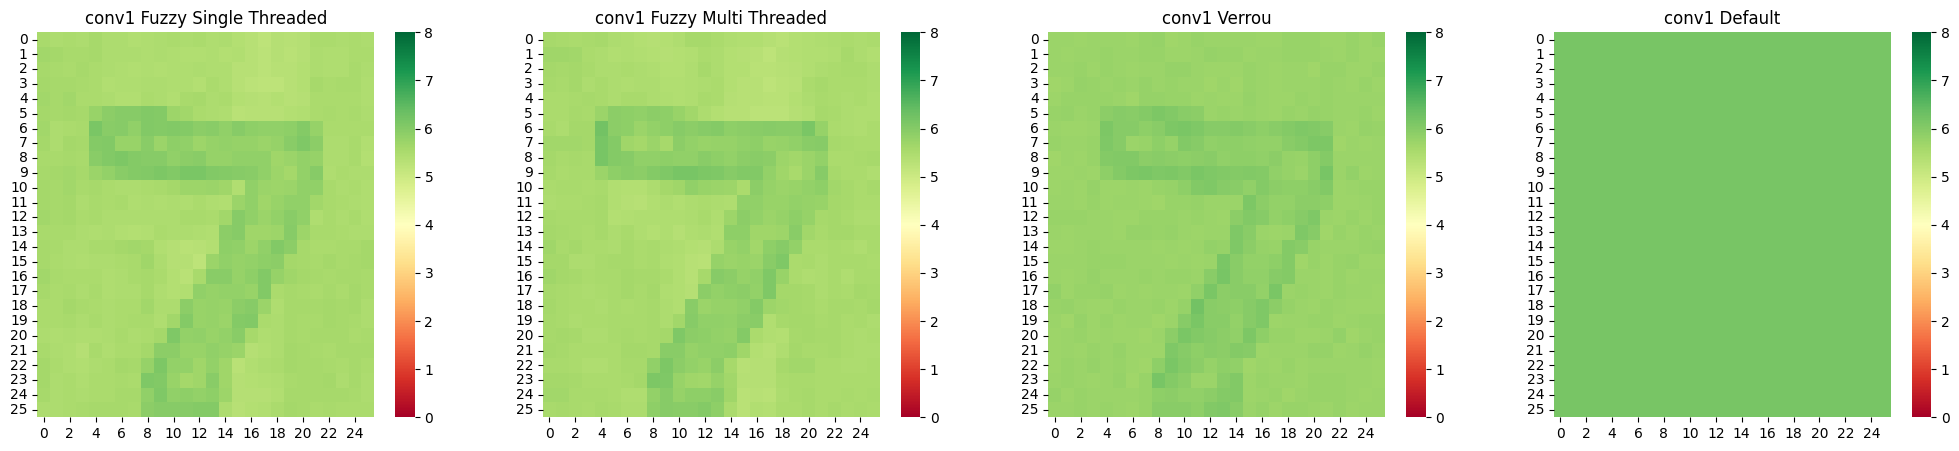

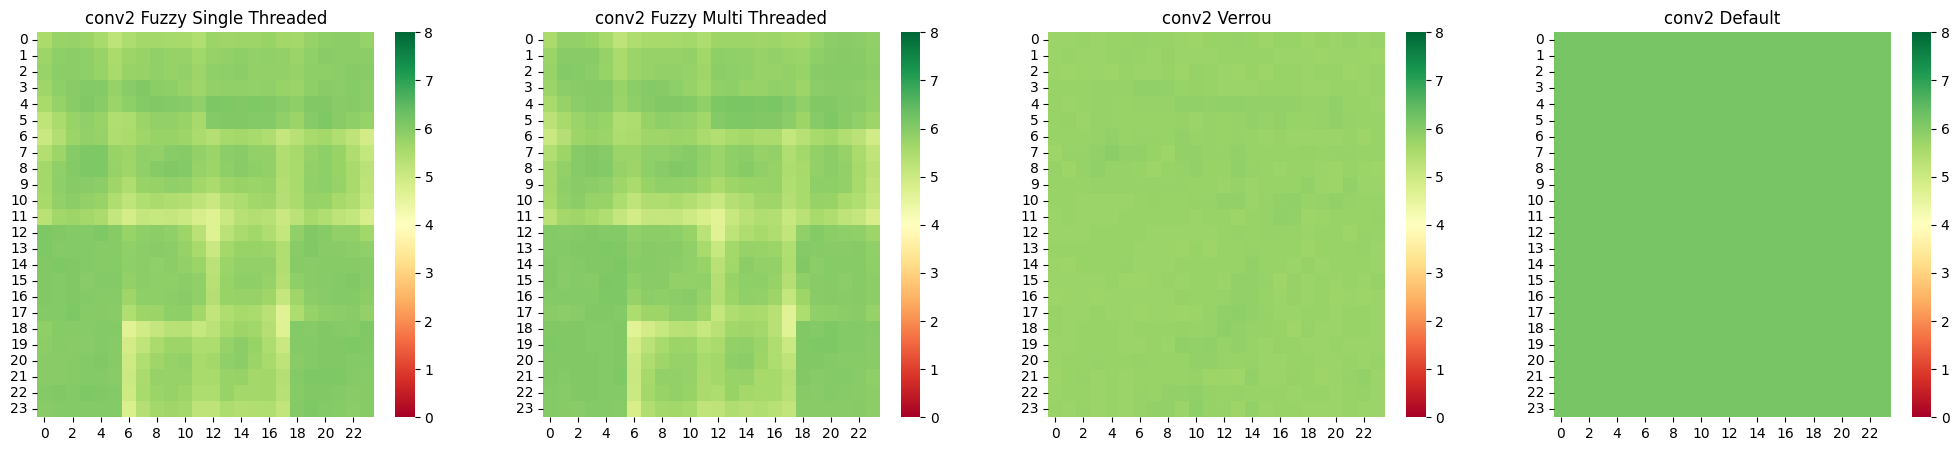

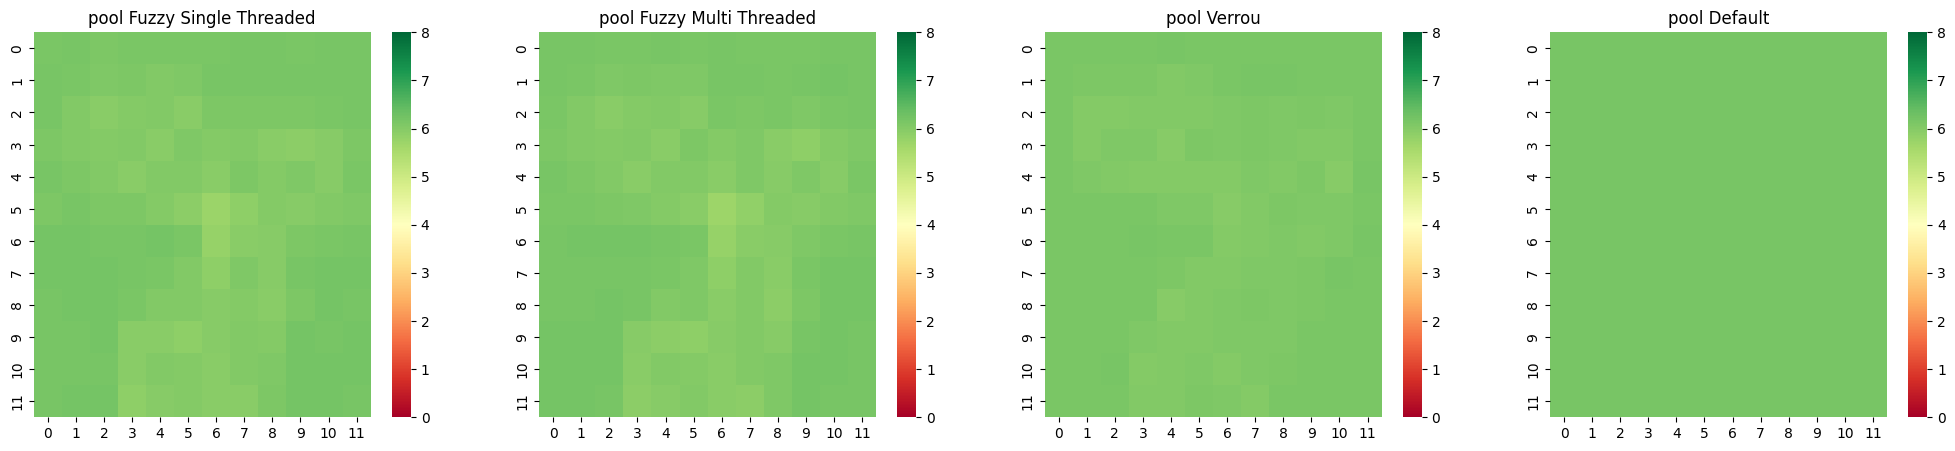

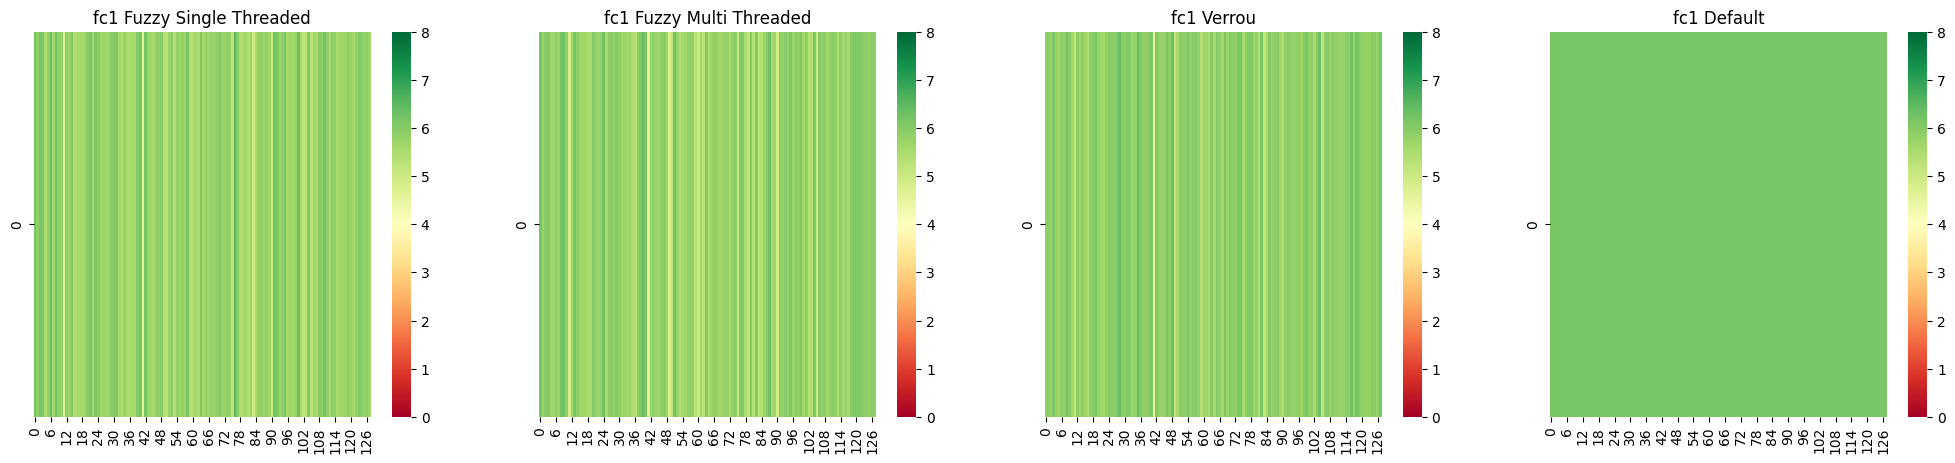

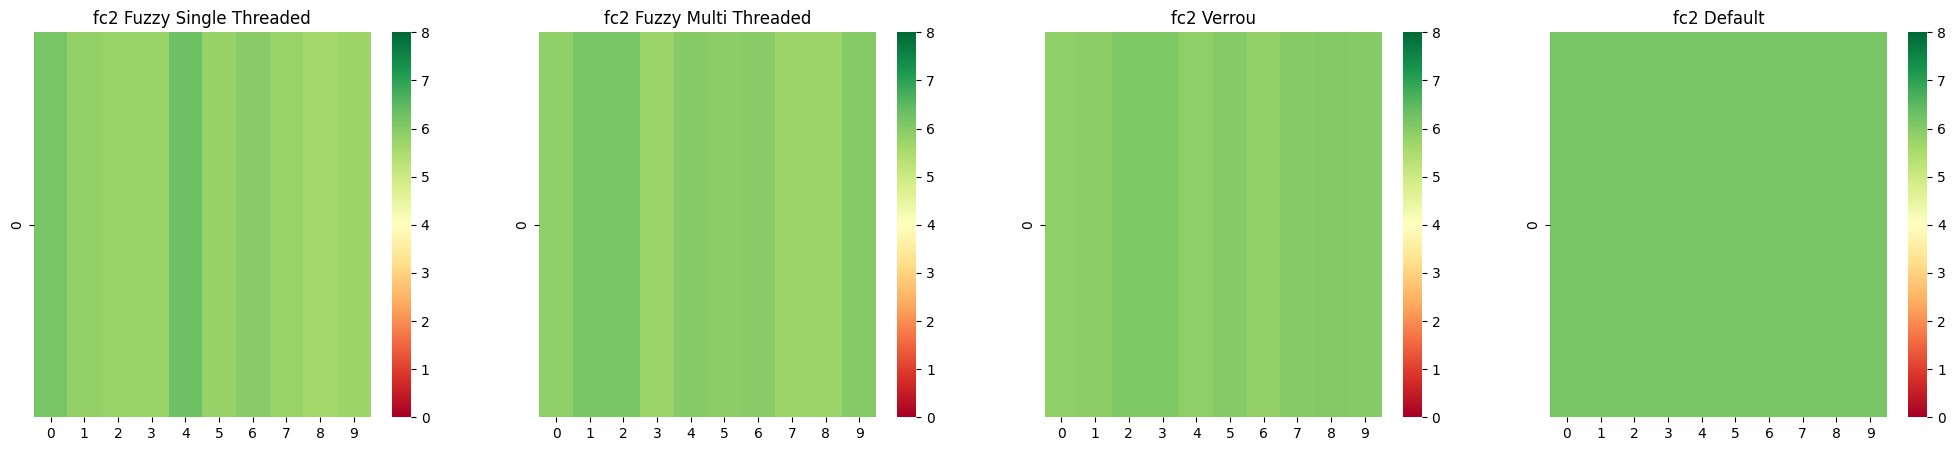

In [49]:

for layer in ['conv1', 'conv2', 'pool', 'fc1', 'fc2']:
# for layer in ['conv1', 'conv2', 'fc1', 'fc2']:
# for layer in ['conv1', ]:
# for layer in ['fc1', 'fc2']:
    embed_fuzzy_singlethread = []
    embed_fuzzy_multithread = []
    embed_verrou = []
    embed_default = []
    for i in range(1,6):
        embed_fuzzy_singlethread.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/fuzzy_singlethread/{layer}_{i}.pkl", 'rb')) )
        embed_fuzzy_multithread.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/fuzzy_multi/{layer}_{i}.pkl", 'rb')) )
        embed_default.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/default/{layer}_{i}.pkl", 'rb')) )
        embed_verrou.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/verrou/{layer}_{i}.pkl", 'rb')) )
        # embed_verrou.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/verrou/mnist_embed_{i}.pkl", 'rb'))[layer][0][layer] )
    embed_fuzzy_singlethread = torch.stack(embed_fuzzy_singlethread)
    embed_fuzzy_multithread = torch.stack(embed_fuzzy_multithread)
    embed_default = torch.stack(embed_default)
    embed_verrou = torch.stack(embed_verrou)

    fig, axes = plt.subplots(1,4, figsize=(25,5))

    if 'fc' in layer: 
        #fuzzy single threaded
        layer_sig = sd.significant_digits(embed_fuzzy_singlethread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_singlethread, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(np.expand_dims(layer_sig[0], axis=0), ax=axes[0], cmap='RdYlGn', vmin=0, vmax=8)
        #fuzzy multithreaded
        layer_sig = sd.significant_digits(embed_fuzzy_multithread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_multithread, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(np.expand_dims(layer_sig[0], axis=0), ax=axes[1], cmap='RdYlGn', vmin=0, vmax=8)
        #verrou
        layer_sig = sd.significant_digits(embed_verrou.type(dtype=torch.float32), reference=torch.mean(embed_verrou, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(np.expand_dims(layer_sig[0], axis=0), ax=axes[2], cmap='RdYlGn', vmin=0, vmax=8)
        #IEEE
        layer_sig = sd.significant_digits(embed_default.type(dtype=torch.float32), reference=torch.mean(embed_default, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(np.expand_dims(layer_sig[0], axis=0), ax=axes[3], cmap='RdYlGn', vmin=0, vmax=8)


    else:
        #fuzzy single threaded
        layer_sig = sd.significant_digits(embed_fuzzy_singlethread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_singlethread, dim=0, dtype=torch.float32),  basis=10)[0]
        sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float32), ax=axes[0], cmap='RdYlGn', vmin=0, vmax=8)
        #fuzzy multi threaded
        layer_sig = sd.significant_digits(embed_fuzzy_multithread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_multithread, dim=0, dtype=torch.float32),  basis=10)[0]
        sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float32), ax=axes[1], cmap='RdYlGn', vmin=0, vmax=8)
        #verrou
        layer_sig = sd.significant_digits(embed_verrou.type(dtype=torch.float32), reference=torch.mean(embed_verrou, dim=0, dtype=torch.float32),  basis=10)[0]
        sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float32), ax=axes[2], cmap='RdYlGn', vmin=0, vmax=8)
        #IEEE
        layer_sig = sd.significant_digits(embed_default.type(dtype=torch.float32), reference=torch.mean(embed_default, dim=0, dtype=torch.float32),  basis=10)[0]
        sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float32), ax=axes[3], cmap='RdYlGn', vmin=0, vmax=8)

    axes[0].set_title(f"{layer} Fuzzy Single Threaded")
    axes[1].set_title(f"{layer} Fuzzy Multi Threaded")
    axes[2].set_title(f"{layer} Verrou")
    axes[3].set_title(f"{layer} Default")
    # break

plt.show()

**Fuzzy Single Threaded with Stdev**

/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)


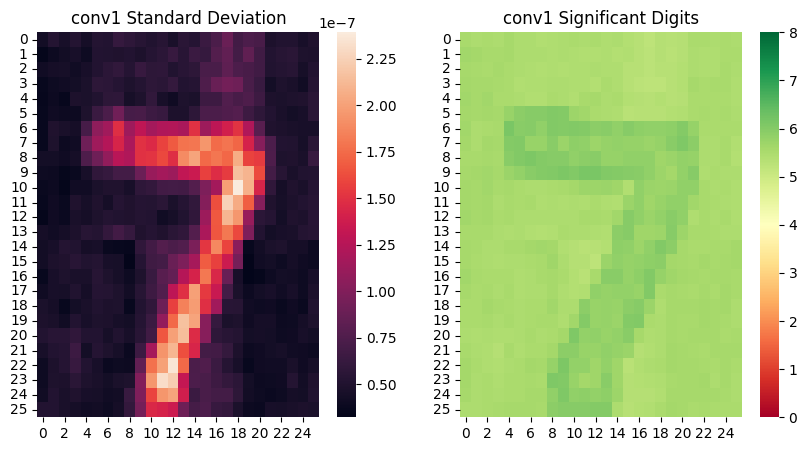

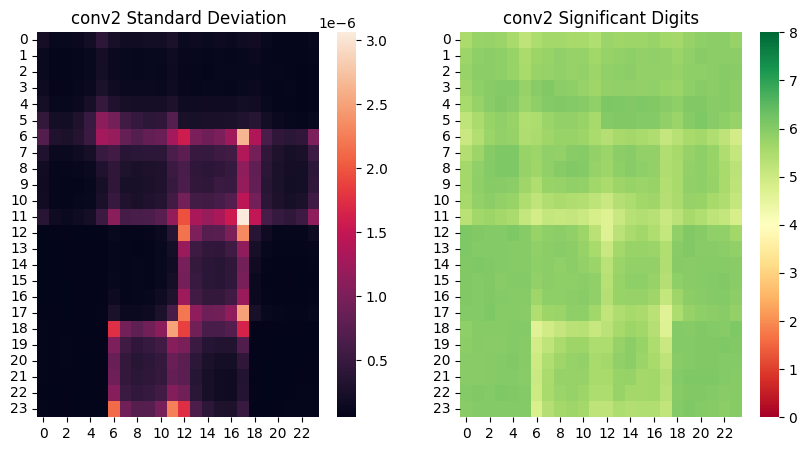

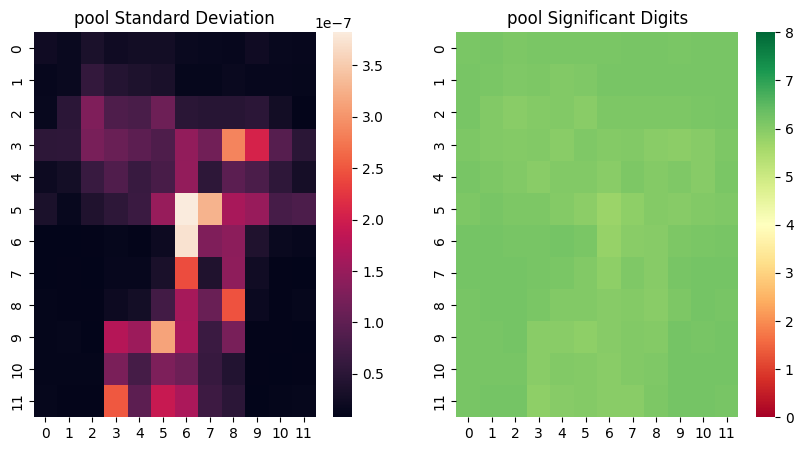

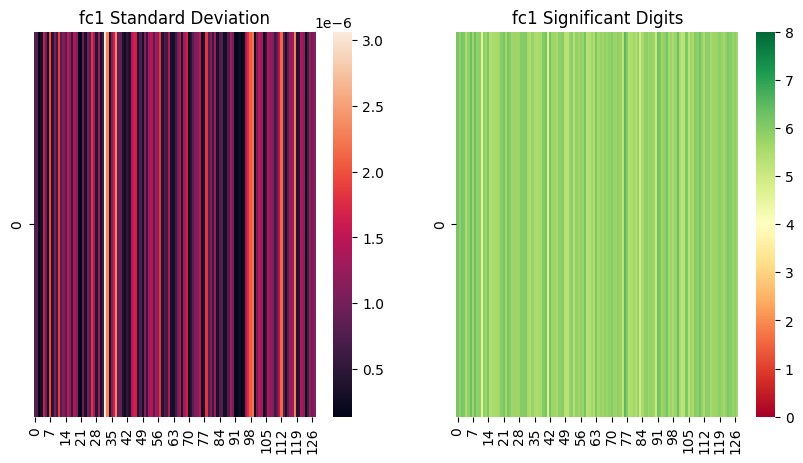

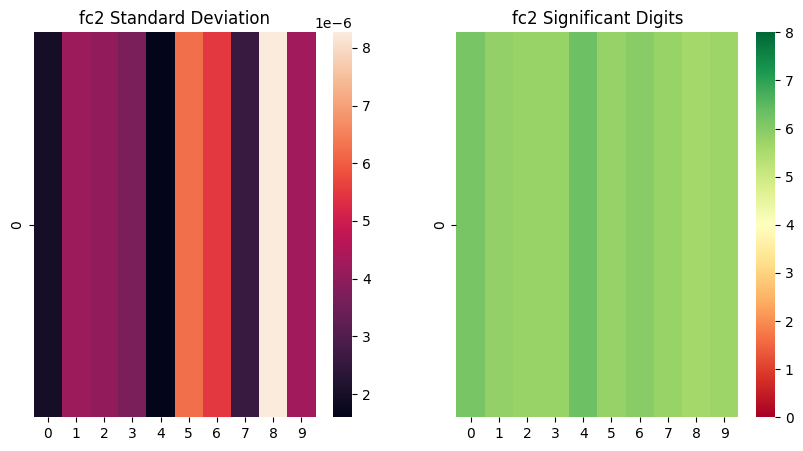

In [41]:

for layer in ['conv1', 'conv2', 'pool', 'fc1', 'fc2']:
# for layer in ['fc1', 'fc2']:
    embed = []
    for i in range(1,6):
        embed.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/fuzzy_singlethread/{layer}_{i}.pkl", 'rb')) )
    embed = torch.stack(embed)

    fig, axes = plt.subplots(1,2, figsize=(10,5))

    if 'fc' in layer: 
        layer_std = torch.std(embed, dim=0)
        sns.heatmap(layer_std[0].unsqueeze(0), ax=axes[0],)

        layer_sig = sd.significant_digits(embed.type(dtype=torch.float32), reference=torch.mean(embed, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(np.expand_dims(layer_sig[0], axis=0), ax=axes[1], cmap='RdYlGn', vmin=0, vmax=8)

    else:
        # conv1_std = torch.mean(torch.std(embed, dim=0), dim=0, dtype=torch.float32)
        layer_std = torch.std(embed, dim=0)[0]
        sns.heatmap(torch.mean(layer_std, dim=0, dtype=torch.float32), ax=axes[0],)
        
        # conv1_sig = np.mean(sd.significant_digits(embed.type(dtype=torch.float32), reference=torch.mean(embed, dim=0, dtype=torch.float32),  basis=10), axis=0)
        layer_sig = sd.significant_digits(embed.type(dtype=torch.float32), reference=torch.mean(embed, dim=0, dtype=torch.float32),  basis=10)[0]
        sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float32), ax=axes[1], cmap='RdYlGn', vmin=0, vmax=8)

    axes[0].set_title(f"{layer} Standard Deviation")
    axes[1].set_title(f"{layer} Significant Digits")
    

plt.show()

#### Averaged Across Data Samples

/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)


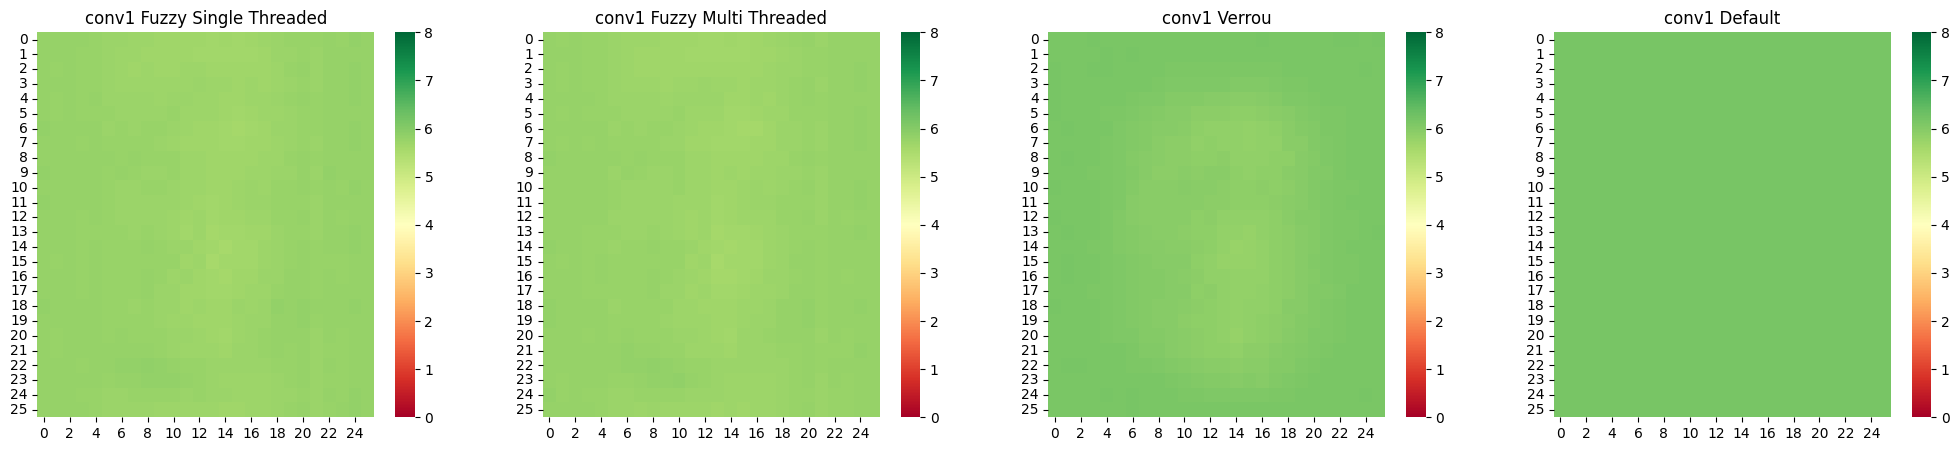

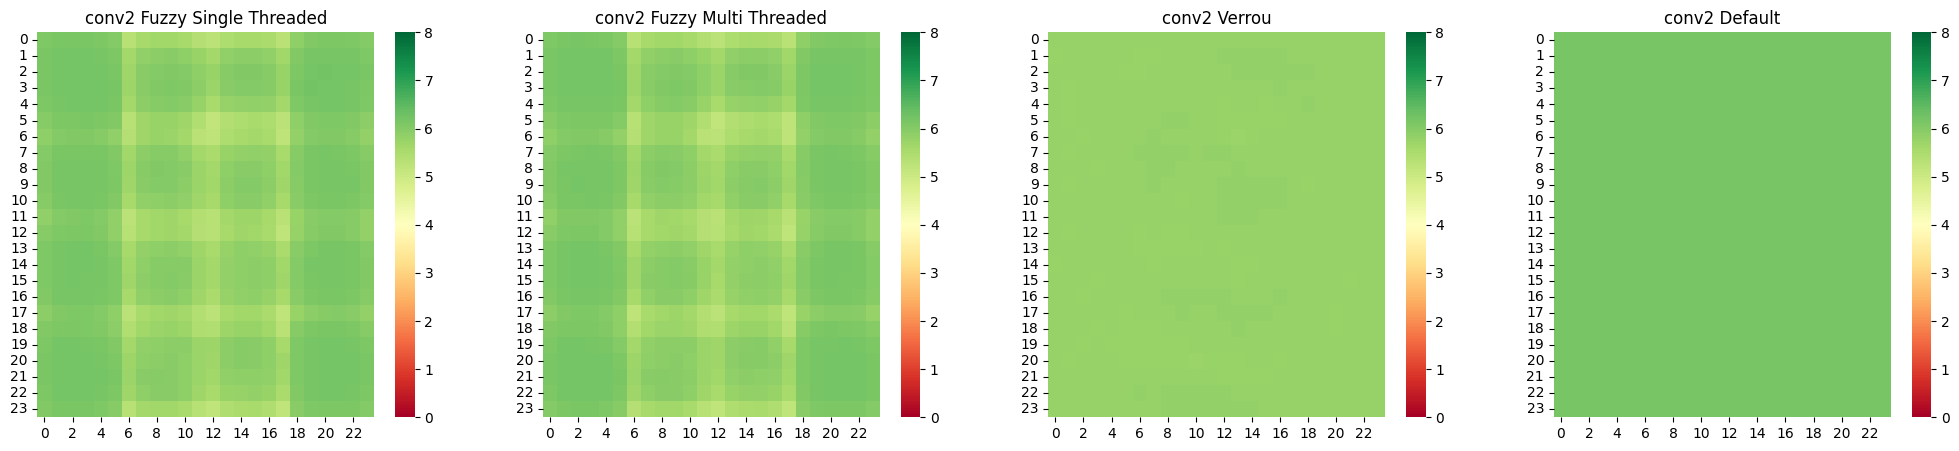

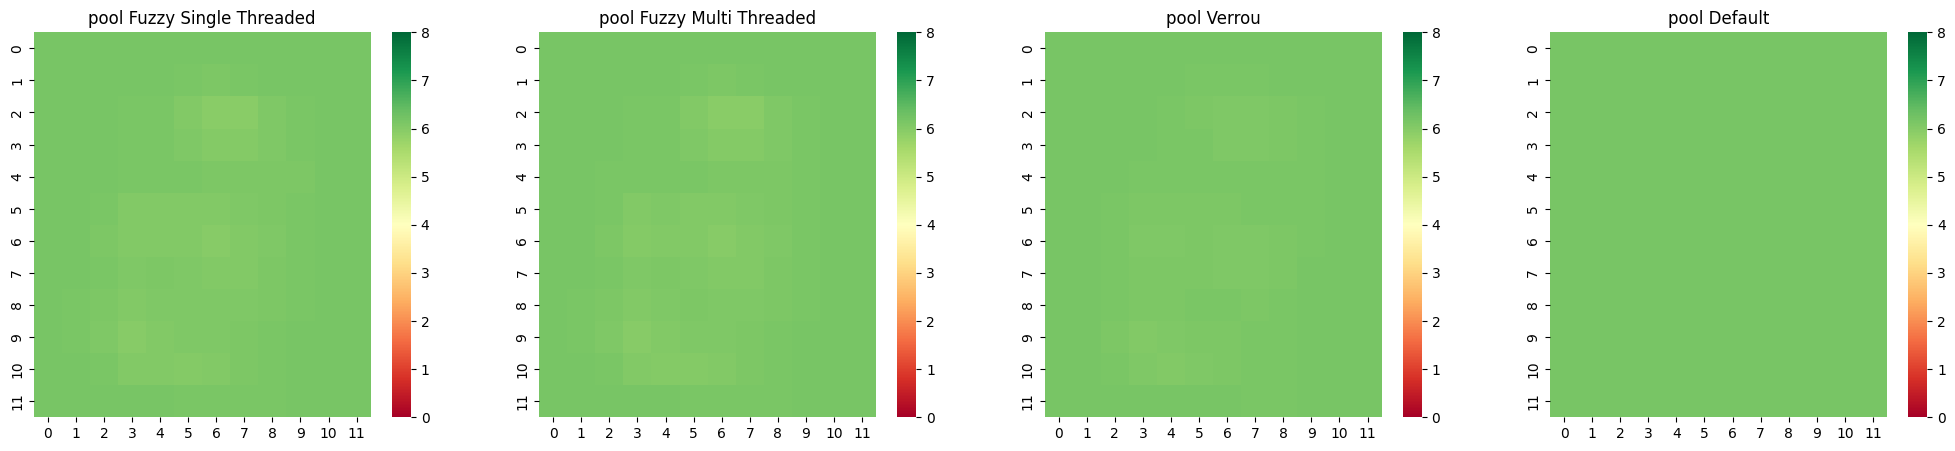

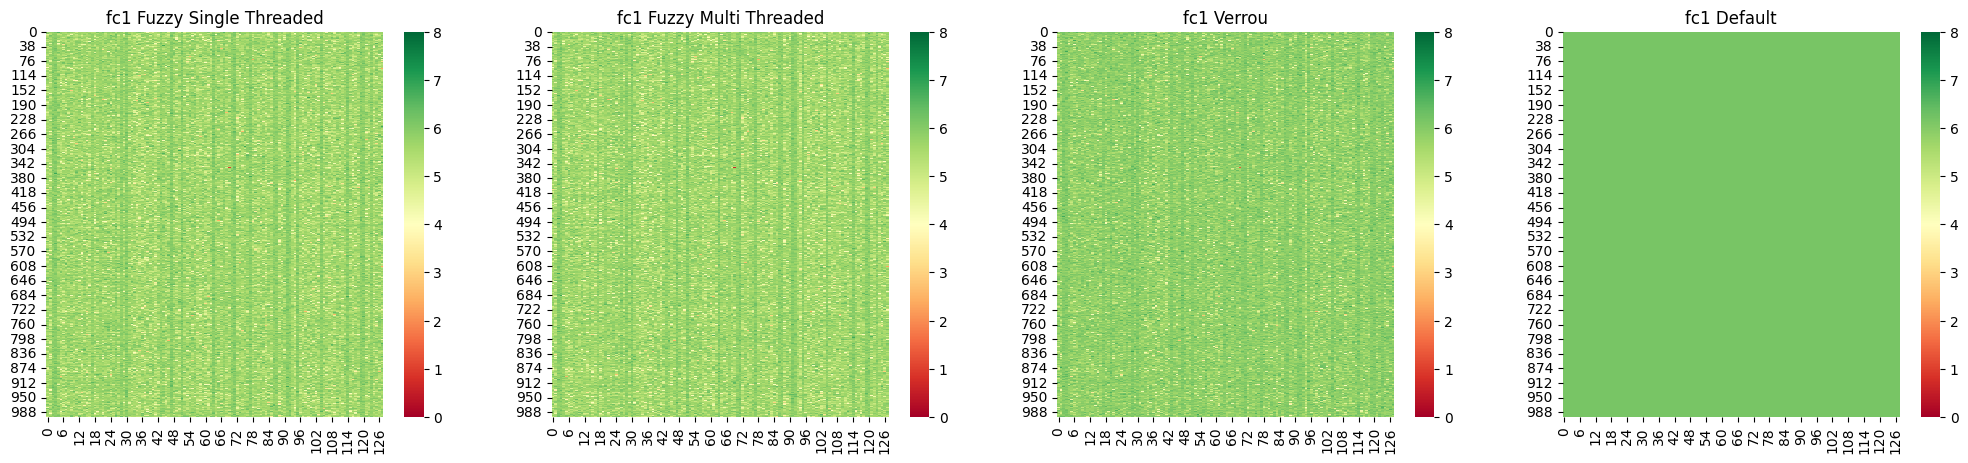

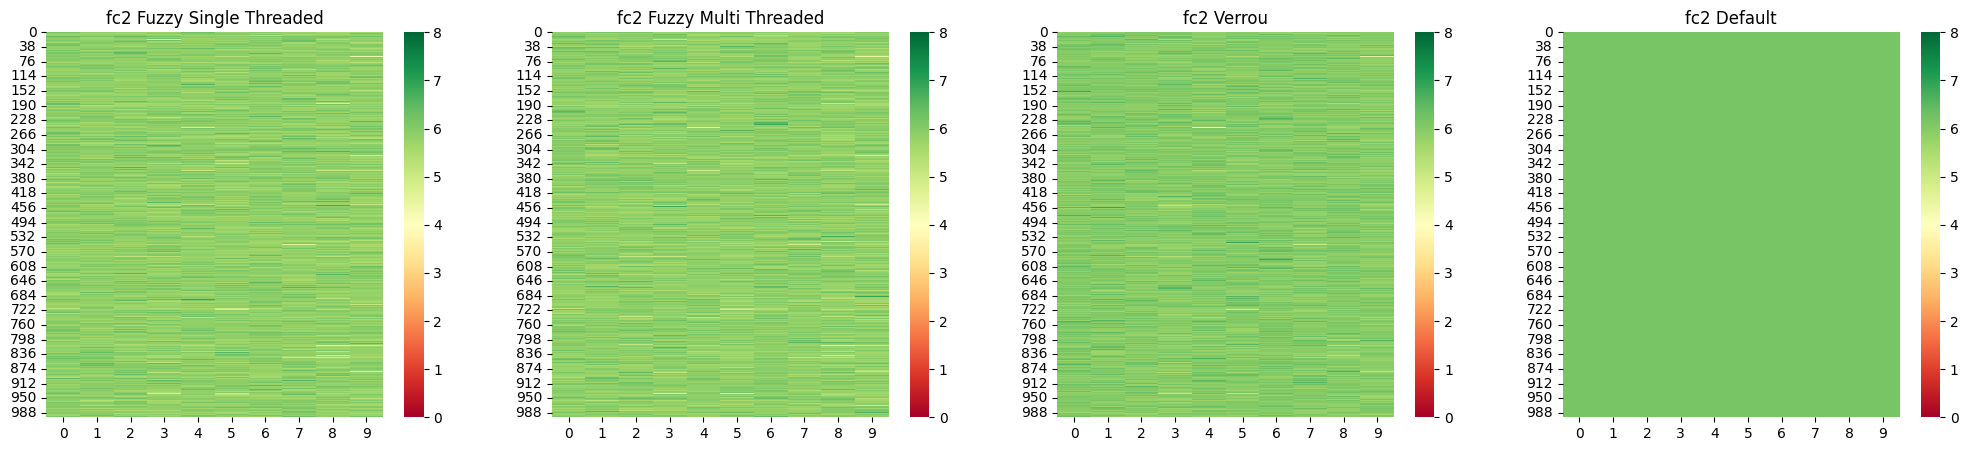

In [51]:

for layer in ['conv1', 'conv2', 'pool', 'fc1', 'fc2']:
# for layer in ['fc1', 'fc2']:
    embed_fuzzy_singlethread = []
    embed_fuzzy_multithread = []
    embed_verrou = []
    embed_default = []
    for i in range(1,6):
        embed_fuzzy_singlethread.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/fuzzy_singlethread/{layer}_{i}.pkl", 'rb')) )
        embed_fuzzy_multithread.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/fuzzy_multi/{layer}_{i}.pkl", 'rb')) )
        embed_verrou.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/verrou/{layer}_{i}.pkl", 'rb')) )
        embed_default.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/default/{layer}_{i}.pkl", 'rb')) )
    embed_fuzzy_singlethread = torch.stack(embed_fuzzy_singlethread)
    embed_fuzzy_multithread = torch.stack(embed_fuzzy_multithread)
    embed_verrou = torch.stack(embed_verrou)
    embed_default = torch.stack(embed_default)

    fig, axes = plt.subplots(1,4, figsize=(25,5))

    if 'fc' in layer: 
        #fuzzy single threaded
        layer_sig = sd.significant_digits(embed_fuzzy_singlethread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_singlethread, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig, ax=axes[0], cmap='RdYlGn', vmin=0, vmax=8)
        #fuzzy multithreaded
        layer_sig = sd.significant_digits(embed_fuzzy_multithread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_multithread, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig, ax=axes[1], cmap='RdYlGn', vmin=0, vmax=8)
        #verrou
        layer_sig = sd.significant_digits(embed_verrou.type(dtype=torch.float32), reference=torch.mean(embed_verrou, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig, ax=axes[2], cmap='RdYlGn', vmin=0, vmax=8)
        #IEEE
        layer_sig = sd.significant_digits(embed_default.type(dtype=torch.float32), reference=torch.mean(embed_default, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig, ax=axes[3], cmap='RdYlGn', vmin=0, vmax=8)


    else:
        #fuzzy single threaded
        layer_sig = np.mean(sd.significant_digits(embed_fuzzy_singlethread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_singlethread, dim=0, dtype=torch.float32),  basis=10), axis=0, dtype=np.float32)
        sns.heatmap(layer_sig[0], ax=axes[0], cmap='RdYlGn', vmin=0, vmax=8)
        #fuzzy multi threaded
        layer_sig = np.mean(sd.significant_digits(embed_fuzzy_multithread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_multithread, dim=0, dtype=torch.float32),  basis=10), axis=0, dtype=np.float32)
        sns.heatmap(layer_sig[0], ax=axes[1], cmap='RdYlGn', vmin=0, vmax=8)
        #verrou
        layer_sig = np.mean(sd.significant_digits(embed_verrou.type(dtype=torch.float32), reference=torch.mean(embed_verrou, dim=0, dtype=torch.float32),  basis=10), axis=0, dtype=np.float32)
        sns.heatmap(layer_sig[0], ax=axes[2], cmap='RdYlGn', vmin=0, vmax=8)
        #IEEE
        layer_sig = np.mean(sd.significant_digits(embed_default.type(dtype=torch.float32), reference=torch.mean(embed_default, dim=0, dtype=torch.float32),  basis=10), axis=0, dtype=np.float32)
        sns.heatmap(layer_sig[0], ax=axes[3], cmap='RdYlGn', vmin=0, vmax=8)

    axes[0].set_title(f"{layer} Fuzzy Single Threaded")
    axes[1].set_title(f"{layer} Fuzzy Multi Threaded")
    axes[2].set_title(f"{layer} Verrou")
    axes[3].set_title(f"{layer} Default")
    

plt.show()

**Fuzzy Single Threaded with Stdev**

/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)


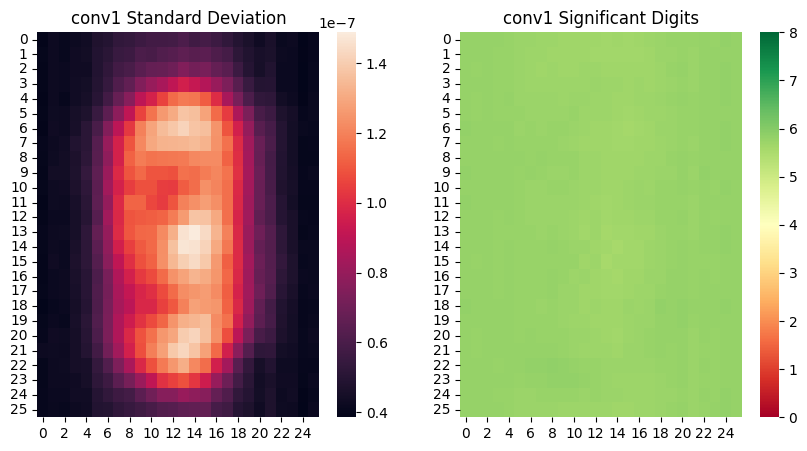

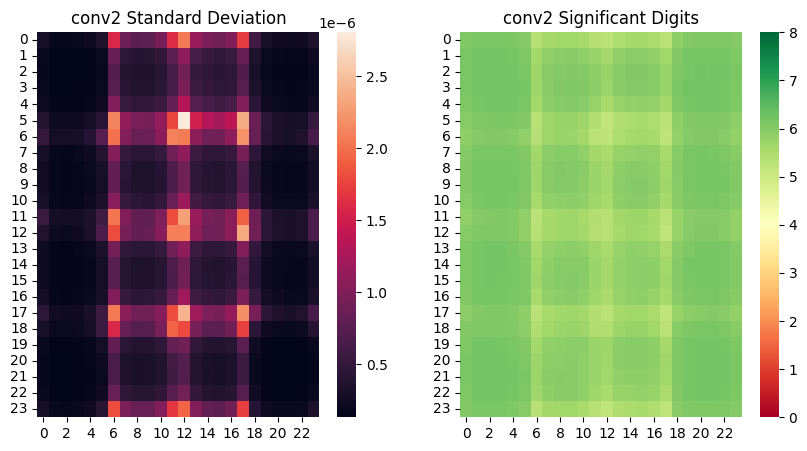

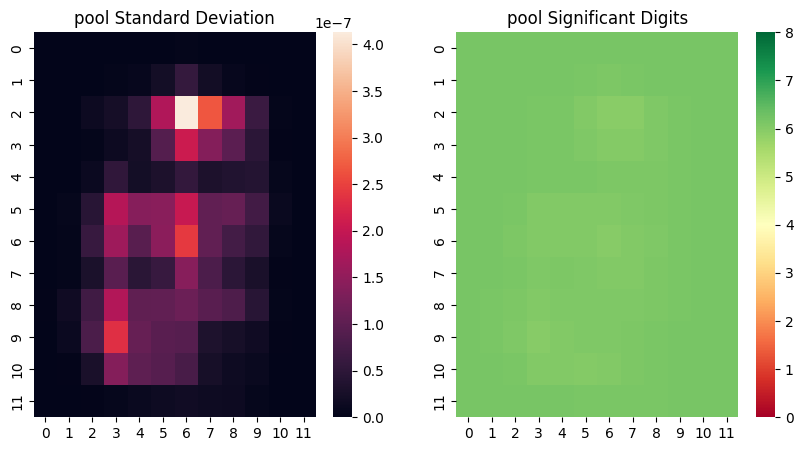

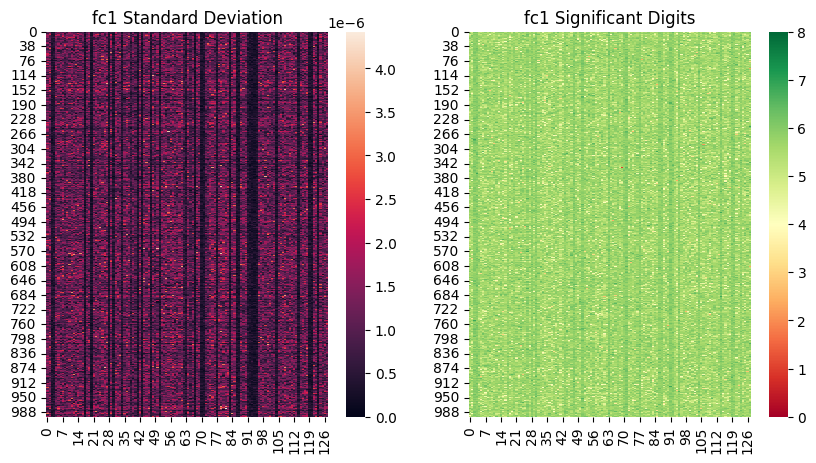

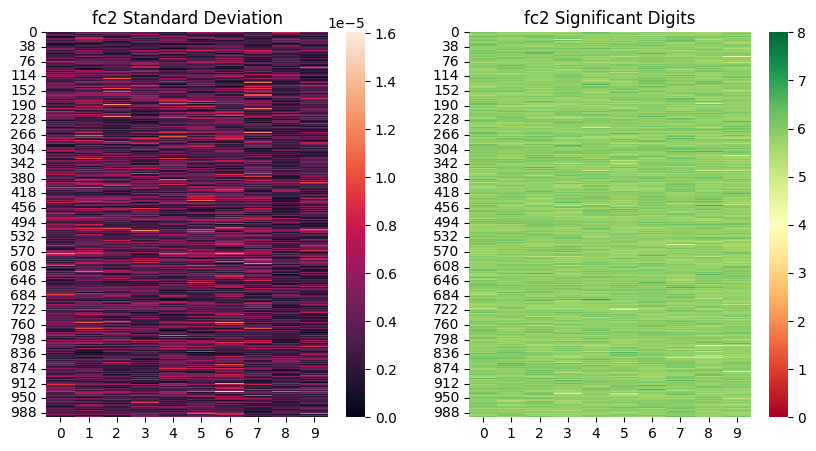

In [ ]:

for layer in ['conv1', 'conv2', 'pool', 'fc1', 'fc2']:
    embed = []
    for i in range(1,6):
        embed.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/fuzzy_singlethread/{layer}_{i}.pkl", 'rb')) )
    embed = torch.stack(embed)

    fig, axes = plt.subplots(1,2, figsize=(10,5))

    if 'fc' in layer: 
        layer_std = torch.std(embed, dim=0)
        sns.heatmap(layer_std, ax=axes[0],)

        layer_sig = sd.significant_digits(embed.type(dtype=torch.float32), reference=torch.mean(embed, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig, ax=axes[1], cmap='RdYlGn', vmin=0, vmax=8)

    else:
        layer_std = torch.mean(torch.std(embed, dim=0), dim=0, dtype=torch.float32)
        sns.heatmap(layer_std[0], ax=axes[0],)
        
        layer_sig = np.mean(sd.significant_digits(embed.type(dtype=torch.float32), reference=torch.mean(embed, dim=0, dtype=torch.float32),  basis=10), axis=0)
        sns.heatmap(layer_sig[0], ax=axes[1], cmap='RdYlGn', vmin=0, vmax=8)

    axes[0].set_title(f"{layer} Standard Deviation")
    axes[1].set_title(f"{layer} Significant Digits")
    

plt.show()

### Additional Variability Checks

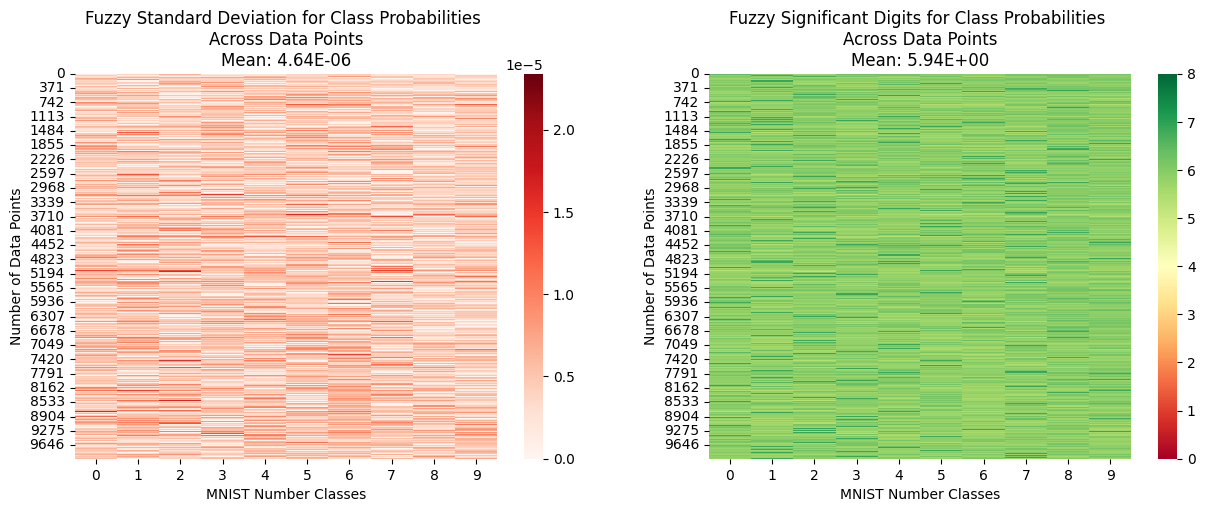

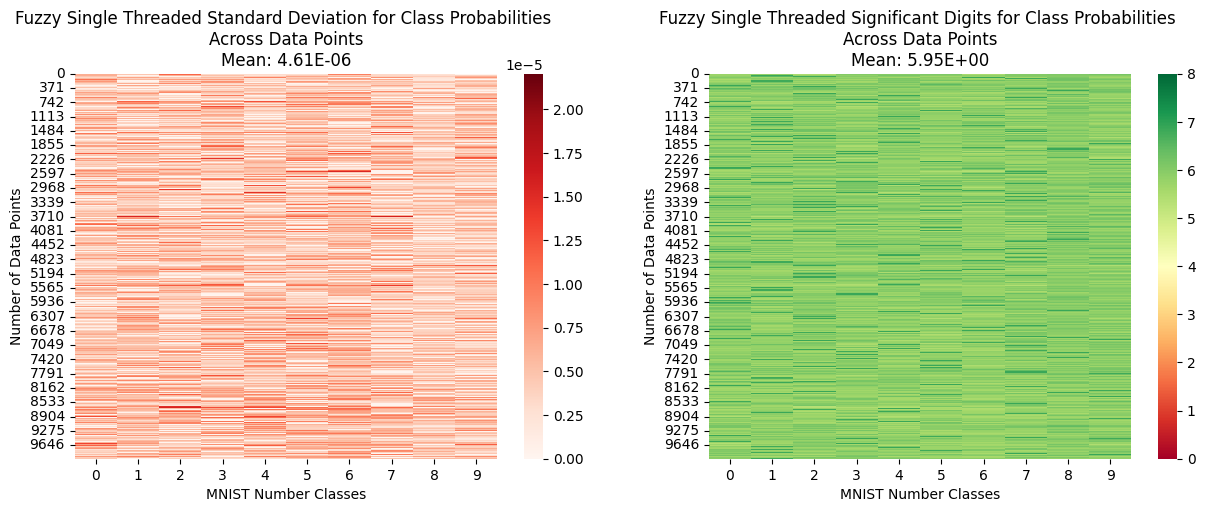

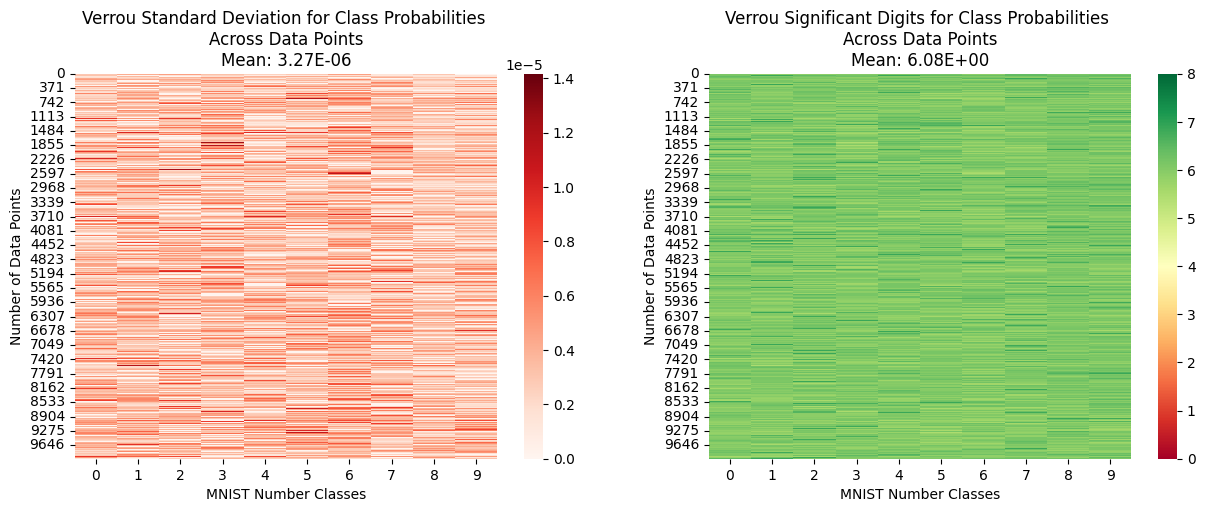

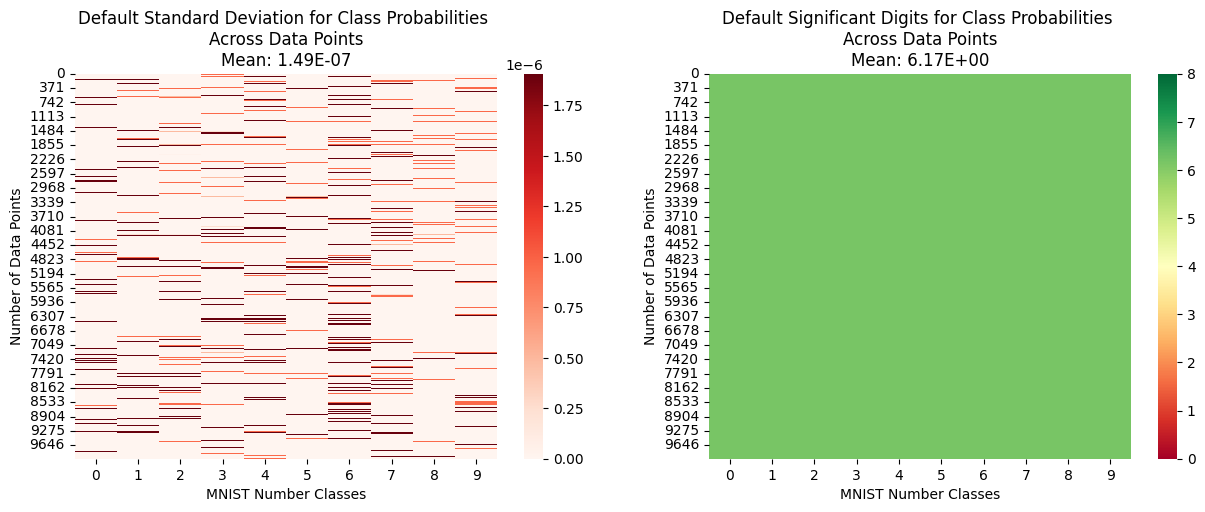

In [34]:
def visualize_class_prob(mca_type, output):
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    class_prob_data = np.std(np.array(list(output.values())), axis=0)
    g = sns.heatmap(class_prob_data, cmap='Reds', ax=axes[0])
    g.set_title(f'{mca_type} Standard Deviation for Class Probabilities \nAcross Data Points\nMean: {np.mean(class_prob_data):.2E}')
    g.set_xlabel('MNIST Number Classes'), g.set_ylabel('Number of Data Points')

    class_prob_data_sig = sd.significant_digits(np.array(list(output.values()), dtype=np.float32), reference=np.mean(np.array(list(output.values()), dtype=np.float32)), basis=10)
    g = sns.heatmap(class_prob_data_sig, cmap='RdYlGn', ax=axes[1], vmin=0, vmax=8)
    g.set_title(f'{mca_type} Significant Digits for Class Probabilities \nAcross Data Points\nMean: {np.mean(class_prob_data_sig):.2E}')
    g.set_xlabel('MNIST Number Classes'), g.set_ylabel('Number of Data Points')

    
    # plt.figure()
    # # print(np.max(np.std(class_prob_data, axis=0)))
    # g = sns.heatmap(np.std(class_prob_data, axis=0).reshape(1,-1), cmap='Reds', ax=axes[2]) # vmin=0, vmax=2.0580248e-06)
    # g.set_yticks([]), g.set_xlabel('MNIST Number Classes')
    # g.set_title(f'{mca_type} Standard Deviation \nAcross Averaged Class Probabilities');

visualize_class_prob(mca_type='Fuzzy', output=fuzzy_output)
plt.show()
visualize_class_prob(mca_type='Fuzzy Single Threaded', output=fuzzy_singlethread_output)
plt.show()
visualize_class_prob(mca_type='Verrou', output=verrou_output)
plt.show()
visualize_class_prob(mca_type='Default', output=default_output)


In [18]:
class_prob_data = np.std(np.array(list(fuzzy_output.values())), axis=0)
# g = sns.heatmap(class_prob_data)
# g.set_title(f'{mca_type} Standard Deviation for Class Probabilities \nAcross Data Points\nMean: {np.mean(class_prob_data):.2E}')
# g.set_xlabel('MNIST Number Classes'), g.set_ylabel('Number of Data Points');

# plt.figure()
# g = sns.heatmap(np.std(class_prob_data, axis=0).reshape(1,-1))
# g.set_yticks([]), g.set_xlabel('MNIST Number Classes')
# g.set_title(f'{mca_type} Standard Deviation \nAcross Averaged Class Probabilities');

df = {}
for i in range(10):
    df[i] = [np.std(class_prob_data, axis=0)[i]]

df = pd.DataFrame(df)
df.index = ['MNIST Class Probabilities Standard Deviation']

df.T

,MNIST Class Probabilities Standard Deviation
0,0.000003
1,0.000003
2,0.000003
3,0.000003
4,0.000003
5,0.000002
6,0.000003
7,0.000003
8,0.000002
9,0.000002


In [ ]:
class_prob_data = np.std(np.array(list(fuzzy_singlethread_output.values())), axis=0)

df = {}
for i in range(10):
    df[i] = [np.std(class_prob_data, axis=0)[i]]

df = pd.DataFrame(df)
df.index = ['MNIST Class Probabilities Standard Deviation']

df.T

,MNIST Class Probabilities Standard Deviation
0,0.000003
1,0.000003
2,0.000003
3,0.000003
4,0.000003
5,0.000003
6,0.000003
7,0.000003
8,0.000002
9,0.000002


In [ ]:
class_prob_data = np.std(np.array(list(verrou_output.values())), axis=0)

df = {}
for i in range(10):
    df[i] = [np.std(class_prob_data, axis=0)[i]]

df = pd.DataFrame(df)
df.index = ['MNIST Class Probabilities Standard Deviation']

df.T

,MNIST Class Probabilities Standard Deviation
0,0.000002
1,0.000002
2,0.000002
3,0.000002
4,0.000002
5,0.000002
6,0.000002
7,0.000002
8,0.000001
9,0.000002


In [ ]:
class_prob_data = np.std(np.array(list(default_output.values())), axis=0)

df = {}
for i in range(10):
    df[i] = [np.std(class_prob_data, axis=0)[i]]

df = pd.DataFrame(df)
df.index = ['MNIST Class Probabilities Standard Deviation']

df.T

,MNIST Class Probabilities Standard Deviation
0,4.657275e-07
1,5.221520e-07
2,4.733344e-07
3,4.630091e-07
4,5.078733e-07
5,4.672007e-07
6,5.510598e-07
7,4.633133e-07
8,3.517193e-07
9,4.304954e-07


## FastSurfer Variability
**TO DO**
* Run 5 more subjects for 
    * fuzzy singlethread 
    * default
* Get dice scores
* Do entropy maps

### Dice Scores
* Calculated using Freesurfer v7.3.1 [```mri_seg_overlap```](https://surfer.nmr.mgh.harvard.edu/fswiki/mri_overlap)

In [133]:
def pad_list(input_list):
    # Check if the length of the list is less than 10
    while len(input_list) < 10:
        input_list.append(np.nan)  # Append NaN until the length is 10
    return input_list


def dice_score_aggregator(file_dir):

    names = {
        "ID": "int",
        "Label name": "str",
        "Red": "int",
        "Green": "int",
        "Blue": "int",
        "Alpha": "int",
    }

    df = pd.read_csv(
        '/home/inesgp/verrou_fastsurfer/FreeSurferColorLUT.txt',
        sep='\s+',
        index_col=0,
        skip_blank_lines=True,
        comment="#",
        header=None,
        names=names.keys(),
        dtype=names,
    )

    df['ID'] = df.index
    df['ID'] = df['ID'].astype(str)

    name_scheme = df.set_index('ID')['Label name'].to_dict()



    aggregated_data_min = {}
    # for sub in ['0003002', '0025011', '0025350', '0025531']:
    for sub in ['0003002', '0025011', '0025248', '0025350', '0025531']:
        aggregated_data = {}

        aggregated_data_min[sub] = {}

        n=5
        for i in range(1, n + 1):
            for j in range(i, n + 1):
                if i == j: continue
                # if i ==4 and j==5: continue
                f = open(f"{file_dir}{sub}_{i}_{j}.json", 'r')
                data = json.load(f)

                # print(data['measures']['dice']['labels'])
                # print(data['names'])

                # Aggregate the values from data['measures']['dice']['labels']
                labels = data['measures']['dice']['labels']
                if labels:
                    for label, dice_scores in labels.items():
                        # If the label is not already in the aggregated_data, initialize it as an empty list
                        if label not in aggregated_data:
                            aggregated_data[label] = []

                        # Append the value to the list for this label
                        aggregated_data[label].append(dice_scores)

                        # if label == '47': print(label, sub, i, j)

        for i in aggregated_data:
            if len(aggregated_data[i]) != 10: aggregated_data[i] = pad_list(aggregated_data[i])
            # print( len(aggregated_data[i]), i )

        df = pd.DataFrame(aggregated_data)
        df = df.rename(columns=name_scheme)
        
        for col in df.columns:
            aggregated_data_min[sub][col] = [ df[col].min() ]


    dice_df = pd.DataFrame([])
    for sub in aggregated_data_min.keys():
        df = pd.DataFrame(aggregated_data_min[sub])
        dice_df = pd.concat([dice_df, df])
        dice_df = dice_df.rename(index={0:f"sub-{sub}"})

    dice_df['subjectID'] = dice_df.index

    # dice_df = dice_df.drop('subjectID', axis=1)

    dice_df = dice_df.reset_index(drop=True)
    dice_df = dice_df.fillna(0)

    return dice_df

fuzzy_ud_dice_df = dice_score_aggregator(file_dir='/home/inesgp/verrou_fastsurfer/dice_scores/fuzzy_ud/')
fuzzy_sr_dice_df = dice_score_aggregator(file_dir='/home/inesgp/verrou_fastsurfer/dice_scores/fuzzy_sr/')
verrou_ud_dice_df = dice_score_aggregator(file_dir='/home/inesgp/verrou_fastsurfer/dice_scores/verrou_ud/')
verrou_sr_dice_df = dice_score_aggregator(file_dir='/home/inesgp/verrou_fastsurfer/dice_scores/verrou_sr/')
default_dice_df = dice_score_aggregator(file_dir='/home/inesgp/verrou_fastsurfer/dice_scores/ieee/')

default_dice_df.to_csv('/home/inesgp/fuzzy-pytorch/FastSurfer_Use_Case/default_min_dice_scores.csv', index=False)
fuzzy_ud_dice_df.to_csv('/home/inesgp/fuzzy-pytorch/FastSurfer_Use_Case/fuzzy_ud_min_dice_scores.csv', index=False)
fuzzy_ud_dice_df.to_csv('/home/inesgp/fuzzy-pytorch/FastSurfer_Use_Case/fuzzy_sr_min_dice_scores.csv', index=False)
verrou_ud_dice_df.to_csv('/home/inesgp/fuzzy-pytorch/FastSurfer_Use_Case/verrou_ud_min_dice_scores.csv', index=False)
verrou_sr_dice_df.to_csv('/home/inesgp/fuzzy-pytorch/FastSurfer_Use_Case/verrou_sr_min_dice_scores.csv', index=False)


In [33]:
fuzzy_ud_dice_df #['Right-Cerebellum-Cortex']

,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,4th-Ventricle,Brain-Stem,Left-Hippocampus,Left-Amygdala,Left-Cerebral-White-Matter,...,Right-Pallidum,Right-Hippocampus,Right-Amygdala,Right-VentralDC,Right-choroid-plexus,Left-Cerebellum-White-Matter,WM-hypointensities,Left-Cerebellum-Cortex,Right-Accumbens-area,subjectID
0,0.999324,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999913,...,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,0.0,sub-0003002
1,1.000000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.999886,...,0.0,1.0,0.0,1.000000,1.0,1.000000,1.0,1.000000,0.0,sub-0025011
2,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.000000,...,1.0,1.0,0.0,1.000000,1.0,1.000000,1.0,1.000000,0.0,sub-0025248
3,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999831,...,1.0,1.0,1.0,0.996016,1.0,0.998733,1.0,0.999119,1.0,sub-0025350
4,1.000000,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.000000,...,0.0,1.0,1.0,1.000000,1.0,1.000000,1.0,0.999700,0.0,sub-0025531


In [132]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def graph_dice(df, fig, color, label):
    # Melt the DataFrame to long format
    long_df = df.melt(id_vars=['subjectID'], var_name='ROI', value_name='Sorensen Dice Scores')

    # Get all unique ROI values for the y-axis range
    all_rois = long_df['ROI'].unique()

    # Add scatter plot for the lower x-axis range (-0.05 to 0.1)
    fig.add_trace(
        go.Scatter(
            x=long_df[long_df['Sorensen Dice Scores'] <= 0.1]['Sorensen Dice Scores'],
            y=long_df['ROI'],
            mode='markers',
            name=label,
            showlegend=False,
            marker=dict(color=color, size=10)
        ),
        row=1, col=1
    )

    # Add scatter plot for the upper x-axis range (0.9 to 1.05)
    fig.add_trace(
        go.Scatter(
            x=long_df[long_df['Sorensen Dice Scores'] >= 0.8]['Sorensen Dice Scores'],
            y=long_df['ROI'],
            mode='markers',
            name=label,
            showlegend=True,
            marker=dict(color=color, size=10)
        ),
        row=1, col=2
    )



    # Update y-axis to include all possible ROIs
    fig.update_yaxes(
        tickvals=all_rois,  # Set the tick values to all unique ROIs
        title_text="ROI",
        row=1, col=1
    )
    fig.update_yaxes(
        tickvals=all_rois,  # Set the tick values to all unique ROIs for the second subplot
        row=1, col=2
    )


# Create a subplot with shared y-axis
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, horizontal_spacing=0.0)

# Call graph_dice for each dataset with appropriate colors and labels
graph_dice(fuzzy_ud_dice_df, fig, color='yellow', label='Fuzzy UD')
graph_dice(fuzzy_sr_dice_df, fig, color='green', label='Fuzzy SR')
graph_dice(verrou_ud_dice_df, fig, color='blue', label='Verrou UD')
graph_dice(verrou_sr_dice_df, fig, color='purple', label='Verrou SR')
graph_dice(default_dice_df, fig, color='red', label='IEEE')


# Custom tick values and labels
custom_ticks = [-0.05, 0, 0.05, 0.1, 0.995, 1, 1.05]
custom_labels = ["-0.05", "0", "...", "", "0.995", "1", "1.05"]

# Update x-axis for both subplots with custom ticks
fig.update_xaxes(
    tickvals=custom_ticks[:4],  # First set of ticks
    ticktext=custom_labels[:4],
    range=[-0.05, 0.1],
    title_text="",
    row=1,
    col=1
)

fig.update_xaxes(
    tickvals=custom_ticks[4:],  # Second set of ticks
    ticktext=custom_labels[4:],
    range=[0.995, 1.005],
    title_text="",
    row=1,
    col=2
)

# Update y-axis
fig.update_yaxes(title_text="ROI", row=1, col=1)

# Add a shared x-axis label
fig.add_annotation(
    x=0.5,
    y=-0.05,  # Adjust position for shared label (within the plot area)
    text="Sorensen Dice Scores",
    showarrow=False,
    xref="paper",
    yref="paper",
    font=dict(size=16),
)

# Layout adjustments
fig.update_layout(
    width=800,
    height=1000,
    showlegend=True,  # Show the legend
    margin=dict(l=10, r=10, t=5, b=10),
)

# Update y-axis
fig.update_yaxes(title_text="ROI", row=1, col=1)


fig.write_image('/home/inesgp/verrou_fastsurfer/fastsurfer_min_dice.pdf', engine="kaleido", format='pdf')

fig.show()


In [123]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, horizontal_spacing=0.0)

fig.add_trace(
    go.Box(
        y=long_df['Sorensen Dice Scores'],
        x=long_df['ROI'],
        name=f'{label} Boxplot',
        boxmean=True,  # Show the mean line in the boxplot
        marker=dict(color='blue'),
        showlegend=False  # Hide the boxplot from legend
    ),
    row=1, col=1
)




Average Verrou UD Dice Score: 0.8971428571428571, Stdev Verrou Dice Score: 0.3046438605542528


/tmp/ipykernel_927471/2867129146.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels(cols, fontsize=35)


Average Verrou SR Dice Score: 0.8971415586156778, Stdev Verrou Dice Score: 0.30464341977214987


/tmp/ipykernel_927471/2867129146.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels(cols, fontsize=35)


Average Fuzzy Dice Scores: 0.8970695373504197, Stdev Fuzzy Dice Score: 0.3046191897705048
Average Fuzzy Dice Scores: 0.8971199232687538, Stdev Fuzzy Dice Score: 0.30463613182237104
Average Default Dice Scores: 1.0, Stdev Default Dice Score: 0.0


/tmp/ipykernel_927471/2867129146.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g3.set_xticklabels([f'{x:.1f}' for x in g2.get_xticks()], size = 30)


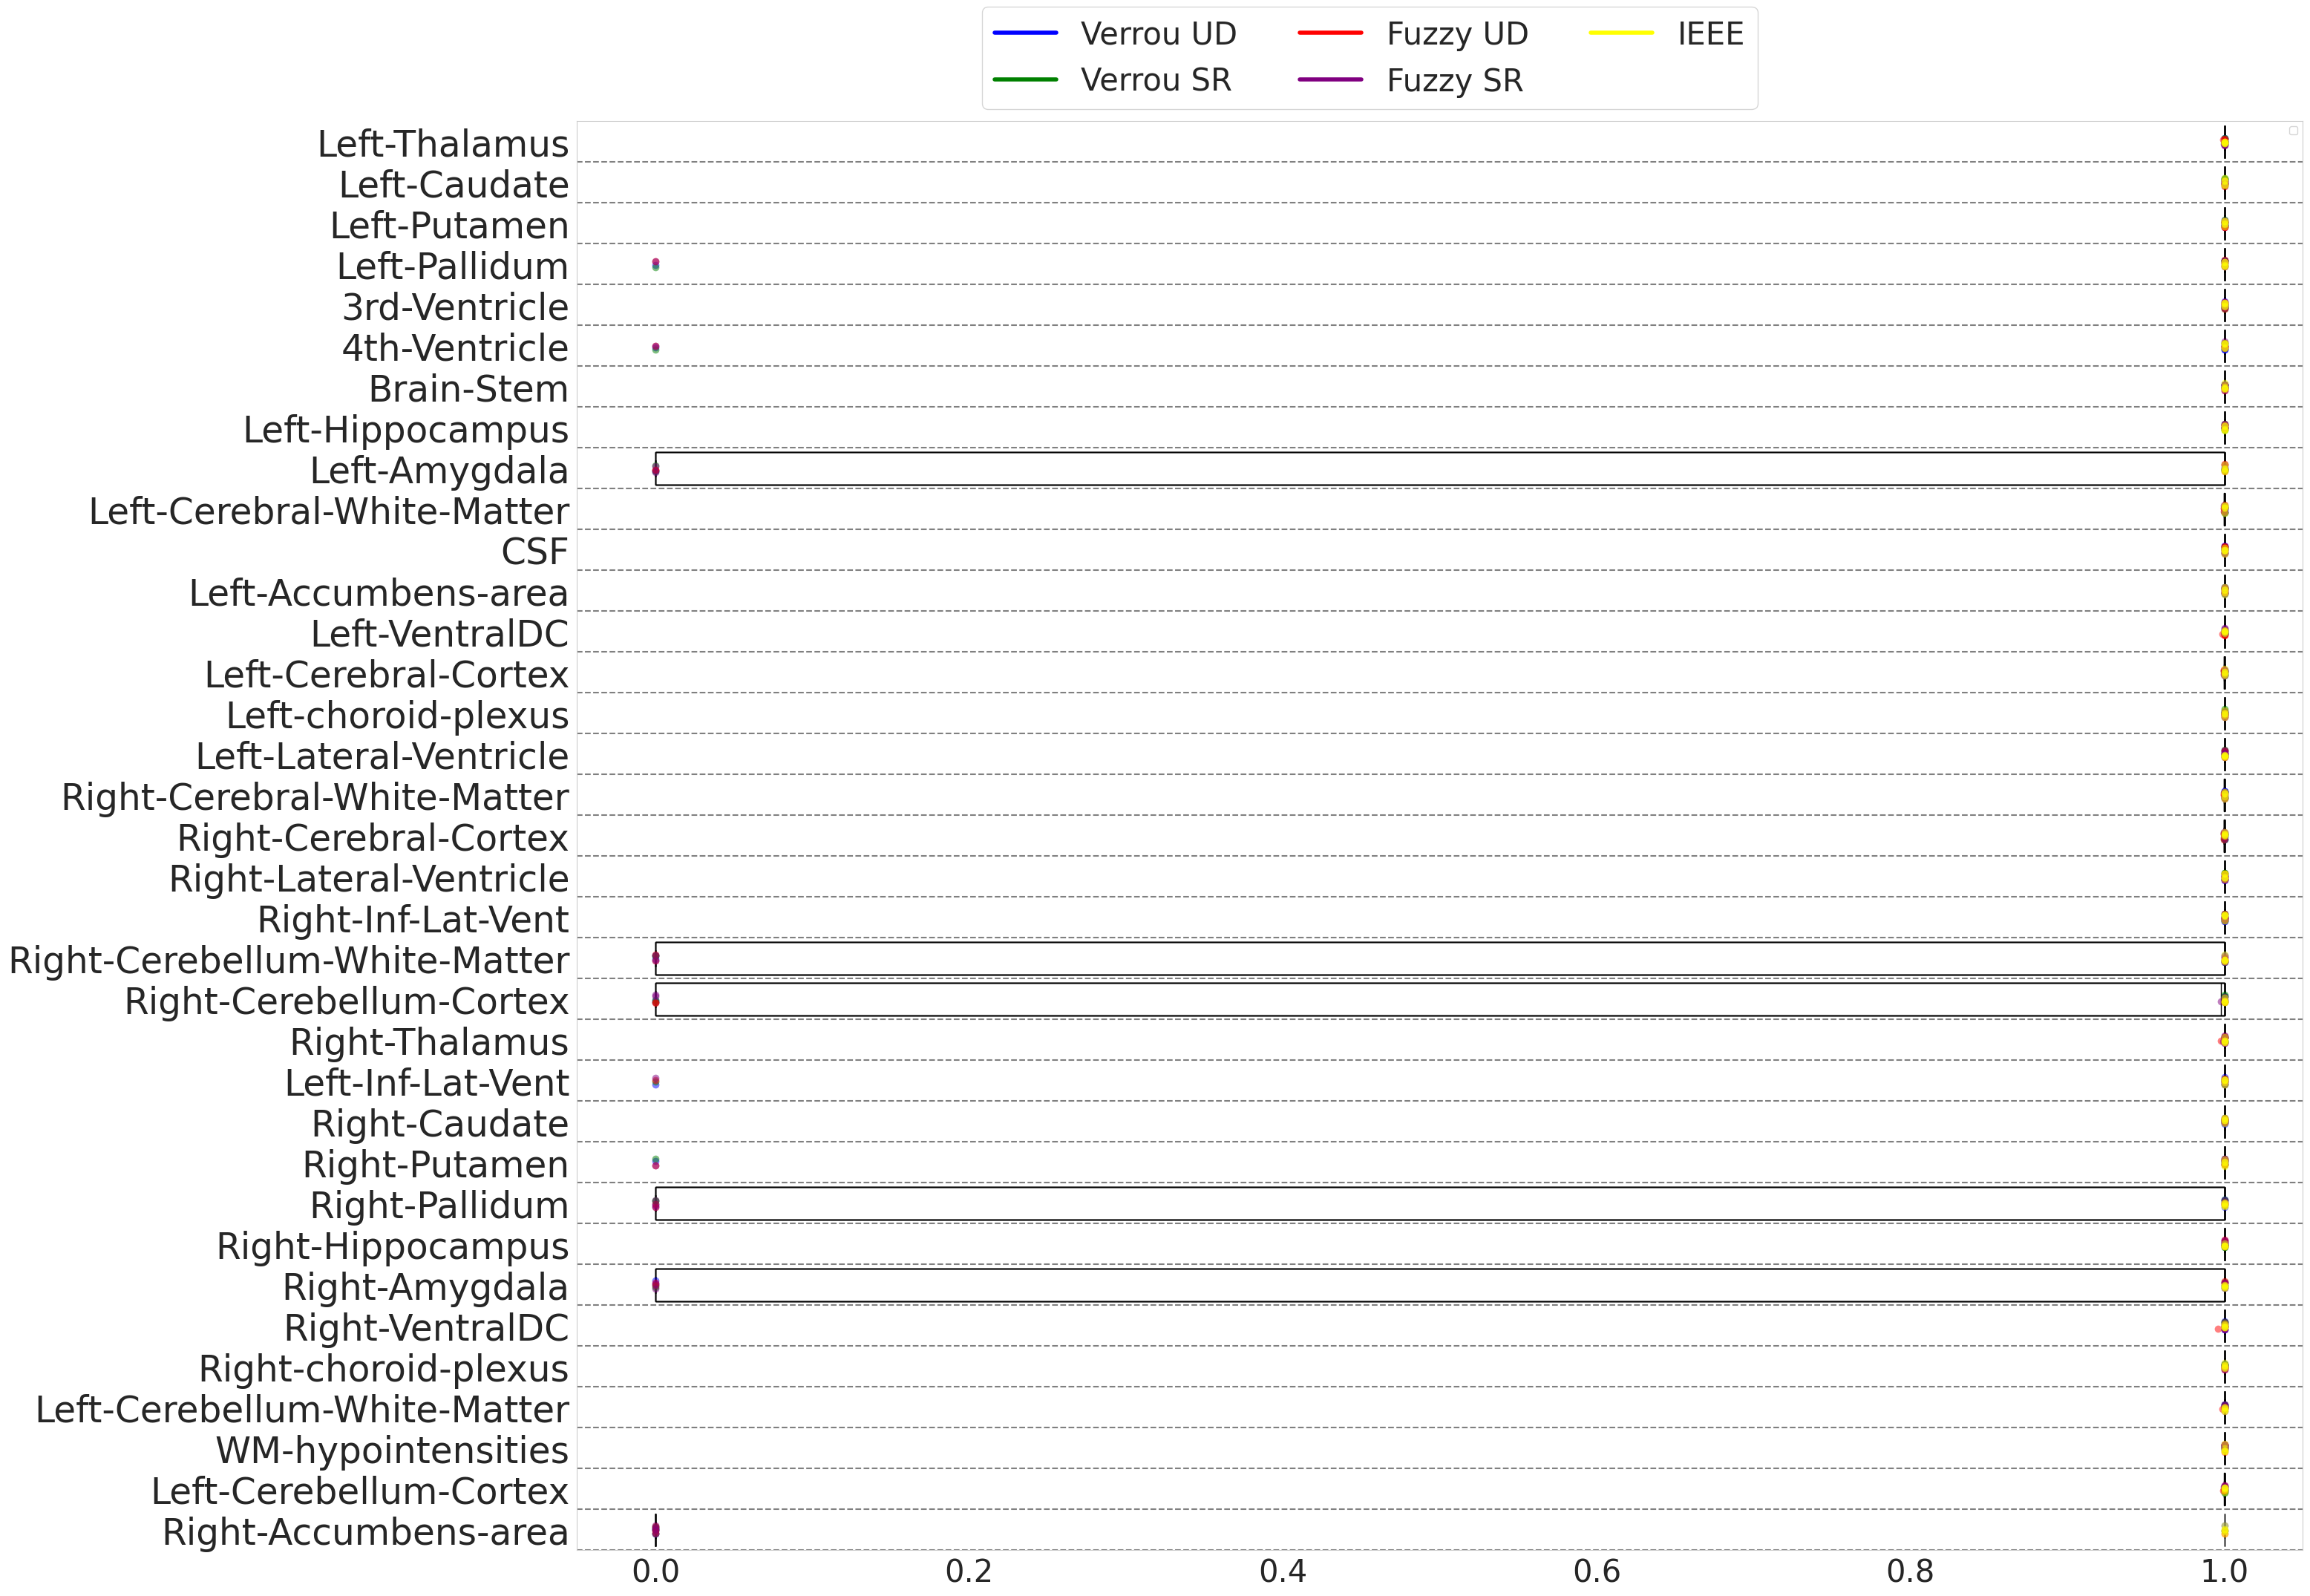

In [34]:
PROPS = {
        'boxprops':{'facecolor':'none', 'edgecolor':'black'},
        'medianprops':{'color':'black'},
        'whiskerprops':{'color':'black'},
        'capprops':{'color':'black'}
}

cols = list(verrou_ud_dice_df.columns)


#Verrou UD
sns.set_style("whitegrid", {'axes.grid' : False})

long_df = verrou_ud_dice_df.melt(id_vars=['subjectID'], var_name='ROI', value_name='Sorensen Dice Scores')
print(f"Average Verrou UD Dice Score: {long_df['Sorensen Dice Scores'].mean()}, Stdev Verrou Dice Score: {long_df['Sorensen Dice Scores'].std()}")
fig, ax = plt.subplots(figsize=(30,25))


# g = sns.stripplot(data=long_df, y='ROI', x='Sorensen Dice Scores', hue='subjectID', color='blue', alpha=0.5, size=7)
g = sns.stripplot(data=long_df, y='ROI', x='Sorensen Dice Scores', label='Verrou UD', color='blue', alpha=0.5, size=7)
sns.boxplot(data=verrou_ud_dice_df, orient='h', showfliers = False, **PROPS)

g.set(xlabel=None)
g.set(ylabel=None)
g.set_yticklabels(cols, fontsize=35)

handles, labels = g.get_legend_handles_labels()
plt.legend(handles[:0], labels[:0]) #Make sure incorrect legend is empty

#Verrou SR
sns.set_style("whitegrid", {'axes.grid' : False})

long_df = verrou_sr_dice_df.melt(id_vars=['subjectID'], var_name='ROI', value_name='Sorensen Dice Scores')
print(f"Average Verrou SR Dice Score: {long_df['Sorensen Dice Scores'].mean()}, Stdev Verrou Dice Score: {long_df['Sorensen Dice Scores'].std()}")

# g = sns.stripplot(data=long_df, y='ROI', x='Sorensen Dice Scores', hue='subjectID', color='blue', alpha=0.5, size=7)
g = sns.stripplot(data=long_df, y='ROI', x='Sorensen Dice Scores', label='Verrou SR', color='green', alpha=0.5, size=7)
sns.boxplot(data=verrou_sr_dice_df, orient='h', showfliers = False, **PROPS)

g.set(xlabel=None)
g.set(ylabel=None)
g.set_yticklabels(cols, fontsize=35)

handles, labels = g.get_legend_handles_labels()
plt.legend(handles[:0], labels[:0]) #Make sure incorrect legend is empty


#fuzzy UD
long_df = fuzzy_ud_dice_df.melt(id_vars=['subjectID'], var_name='ROI', value_name='Sorensen Dice Scores')
print(f"Average Fuzzy Dice Scores: {long_df['Sorensen Dice Scores'].mean()}, Stdev Fuzzy Dice Score: {long_df['Sorensen Dice Scores'].std()}")

# g2 = sns.stripplot(data=long_df, y='ROI', x='Sorensen Dice Scores', hue='subjectID', color='red', alpha=0.5, size=7)
g2 = sns.stripplot(data=long_df, y='ROI', x='Sorensen Dice Scores', label='Fuzzy UD', color='red', alpha=0.5, size=7)
sns.boxplot(data=fuzzy_ud_dice_df, orient='h', showfliers = False, **PROPS)
# g2.set_xticklabels([f'{x:.1f}' for x in g2.get_xticks()], size = 30)
g2.set(xlabel=None)
g2.set(ylabel=None)

handles2, labels2 = g2.get_legend_handles_labels()  
plt.legend(handles2[:0], labels2[:0]) #Make sure incorrect legend is empty

#fuzzy SR
long_df = fuzzy_sr_dice_df.melt(id_vars=['subjectID'], var_name='ROI', value_name='Sorensen Dice Scores')
print(f"Average Fuzzy Dice Scores: {long_df['Sorensen Dice Scores'].mean()}, Stdev Fuzzy Dice Score: {long_df['Sorensen Dice Scores'].std()}")

# g2 = sns.stripplot(data=long_df, y='ROI', x='Sorensen Dice Scores', hue='subjectID', color='red', alpha=0.5, size=7)
g2 = sns.stripplot(data=long_df, y='ROI', x='Sorensen Dice Scores', label='Fuzzy SR', color='purple', alpha=0.5, size=7)
sns.boxplot(data=fuzzy_sr_dice_df, orient='h', showfliers = False, **PROPS)
# g2.set_xticklabels([f'{x:.1f}' for x in g2.get_xticks()], size = 30)
g2.set(xlabel=None)
g2.set(ylabel=None)

handles2, labels2 = g2.get_legend_handles_labels()  
plt.legend(handles2[:0], labels2[:0]) #Make sure incorrect legend is empty


# Default
long_df = default_dice_df.melt(id_vars=['subjectID'], var_name='ROI', value_name='Sorensen Dice Scores')
print(f"Average Default Dice Scores: {long_df['Sorensen Dice Scores'].mean()}, Stdev Default Dice Score: {long_df['Sorensen Dice Scores'].std()}")

# g3 = sns.stripplot(data=long_df, y='ROI', x='Sorensen Dice Scores', hue='subjectID', color='red', alpha=0.5, size=7)
g3 = sns.stripplot(data=long_df, y='ROI', x='Sorensen Dice Scores', label='Default', color='yellow', alpha=0.5, size=7)
sns.boxplot(data=default_dice_df, orient='h', showfliers = False, **PROPS)
g3.set_xticklabels([f'{x:.1f}' for x in g2.get_xticks()], size = 30)
g3.set(xlabel=None)
g3.set(ylabel=None)


handles3, labels3 = g3.get_legend_handles_labels()  
plt.legend(handles3[:0], labels3[:0]) #Make sure incorrect legend is empty


custom_lines = [
    Line2D([0], [0], color='blue', lw=4),
    Line2D([0], [0], color='green', lw=4),
    Line2D([0], [0], color='red', lw=4),
    Line2D([0], [0], color='purple', lw=4),
    Line2D([0], [0], color='yellow', lw=4)
    ]

fig.legend(custom_lines, ['Verrou UD', 'Verrou SR', 'Fuzzy UD', 'Fuzzy SR', 'IEEE'], ncol=3, fontsize=30, bbox_to_anchor=(0.3, 0.95), loc='upper left');
for i in range(35):
    g.axhline(y = i+0.5,xmin = 0, xmax = 1, linestyle = "dashed", color ='grey') 
    # g2.axhline(y = i+0.5,xmin = 0, xmax = 1, linestyle = "dashed", color ='grey') 
    # g3.axhline(y = i+0.5,xmin = 0, xmax = 1, linestyle = "dashed", color ='grey') 

plt.savefig(f'/home/inesgp/verrou_fastsurfer/fastsurfer_min_dice.pdf', bbox_inches='tight');

### Entropy Maps
* Run ```calculate_entropy.py```

In [37]:
directory = '/home/inesgp/verrou_fastsurfer/'
# verrou_entropy_stats = {'min': [], 'max': [], 'subject': []}
# fuzzy_entropy_stats = {'min': [], 'max': [], 'subject': []}

def compile_general_entropy(directory, flag):
    entropy_stats = {'min': [], 'max': [], 'subject': []}

    for subject in ['0003002', '0025011', '0025248', '0025350', '0025531']:
        print(subject)
        # result = entropy_voxel(f'/home/inesgp/verrou_fastsurfer/sub-{subject}', sub=subject)

        # img = nib.load(f"{directory}/sub-{subject}/{subject}_1/mri/aseg.auto_noCCseg.mgz")
        entropy = np.load(f"{directory}/entropy_maps/{flag}_{subject}.npy")

        print(len(np.unique(entropy)), entropy.min(), entropy.max() )
        entropy_stats['min'].append( entropy.min() )
        entropy_stats['max'].append( entropy.max() )
        entropy_stats['subject'].append( subject )

    return entropy_stats

ieee_entropy_stats = compile_general_entropy(directory='/home/inesgp/verrou_fastsurfer/', flag='ieee')
fuzzy_entropy_stats = compile_general_entropy(directory='/home/inesgp/verrou_fastsurfer/', flag='fuzzy')
verrou_entropy_stats = compile_general_entropy(directory='/home/inesgp/verrou_fastsurfer/', flag='verrou')

0003002
1 0.0 0.0
0025011
1 0.0 0.0
0025248
1 0.0 0.0
0025350
1 0.0 0.0
0025531
1 0.0 0.0
0003002
5 0.0 1.0549201679861442
0025011
5 0.0 1.0549201679861442
0025248
5 0.0 1.0549201679861442
0025350
5 0.0 1.0549201679861442
0025531
5 0.0 1.0549201679861442
0003002
3 0.0 0.6730116670092565
0025011
3 0.0 0.6730116670092565
0025248
3 0.0 0.6730116670092565
0025350
5 0.0 1.0549201679861442
0025531
6 0.0 1.3321790402101223


IEEE average max entropy: 0.0, IEEE average min entropy: 0.0
Verrou average max entropy: 0.8812268418448073, Verrou average min entropy: 0.0
Fuzzy average max entropy: 1.0549201679861442, Fuzzy average min entropy: 0.0


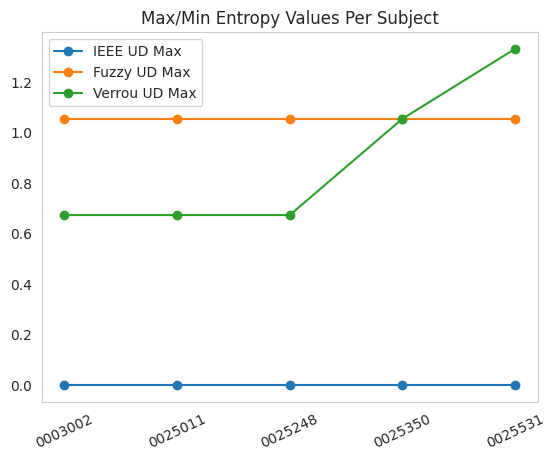

In [42]:
# plt.plot(ieee_entropy_stats['min'], marker='o', label='IEEE UD Min')
plt.plot(ieee_entropy_stats['max'], marker='o', label='IEEE UD Max')
# plt.plot(fuzzy_entropy_stats['min'], marker='o', label='Fuzzy UD Min')
plt.plot(fuzzy_entropy_stats['max'], marker='o', label='Fuzzy UD Max')
# plt.plot(verrou_entropy_stats['min'], marker='o', label='Verrou UD Min')
plt.plot(verrou_entropy_stats['max'], marker='o', label='Verrou UD Max')

plt.legend(), plt.xticks(range(len(ieee_entropy_stats['subject'])), ieee_entropy_stats['subject'], rotation=25)  # Set ticks and labels
plt.title('Max/Min Entropy Values Per Subject');

print(f"IEEE average max entropy: {np.mean(ieee_entropy_stats['max'])}, IEEE average min entropy: {np.mean(ieee_entropy_stats['min'])}")
print(f"Verrou average max entropy: {np.mean(verrou_entropy_stats['max'])}, Verrou average min entropy: {np.mean(verrou_entropy_stats['min'])}")
print(f"Fuzzy average max entropy: {np.mean(fuzzy_entropy_stats['max'])}, Fuzzy average min entropy: {np.mean(fuzzy_entropy_stats['min'])}")


0003002


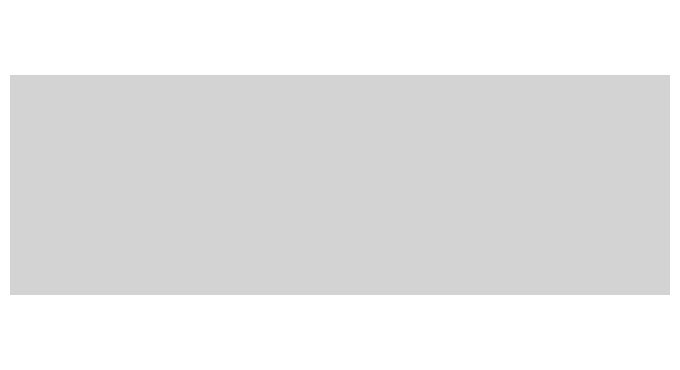

In [59]:
entropy_directory = '/mnt/lustre/inesgp/'
img_directory = '/home/inesgp/verrou_fastsurfer/'

cmap0 = LinearSegmentedColormap.from_list('', ['lightgray', 'red'])

for subject in ['0003002', ]:
    print(subject)
    # result = entropy_voxel(f'/home/inesgp/verrou_fastsurfer/sub-{subject}', sub=subject)

    img = nib.load(f"{img_directory}/sub-{subject}/{subject}_1/mri/aseg.auto_noCCseg.mgz")
    entropy = np.load(f"{entropy_directory}/entropy_maps/fuzzy_ud_{subject}.npy")

    img = nib.nifti1.Nifti1Image(entropy, img.affine) 
    display = plotting.plot_img(img, cut_coords=(0,0,30), black_bg=False, draw_cross=False, bg_img=None,cmap=cmap0, annotate=False, vmin=0, vmax=1.6) #, axes=axes[0])
    # display.savefig(f"/home/ines/Documents/Thesis/FreeSurfer/special_fig/fs_sub-0027012_entropy.png")


    # break


0003002


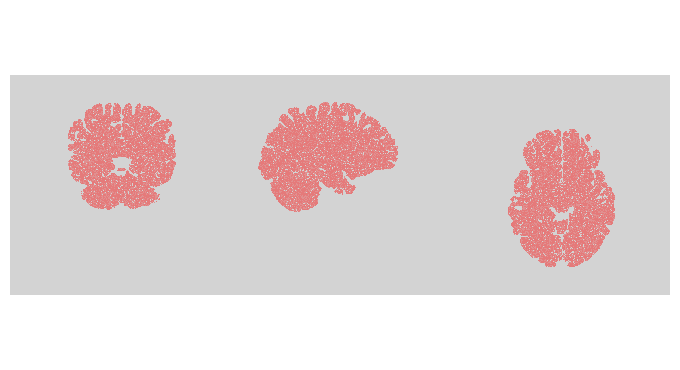

In [ ]:
directory = '/home/inesgp/verrou_fastsurfer/'
cmap0 = LinearSegmentedColormap.from_list('', ['lightgray', 'red'])

directory = '/home/inesgp/verrou_fastsurfer/'
for subject in ['0003002', '0025011', '0025248', '0025350', '0025531']:
    print(subject)
    # result = entropy_voxel(f'/home/inesgp/verrou_fastsurfer/sub-{subject}', sub=subject)

    img = nib.load(f"{directory}/sub-{subject}/{subject}_1/mri/aseg.auto_noCCseg.mgz")
    entropy = np.load(f"{directory}/entropy_maps/fuzzy_{subject}.npy")

    img = nib.nifti1.Nifti1Image(entropy, img.affine) 
    display = plotting.plot_img(img, cut_coords=(0,0,30), black_bg=False, draw_cross=False, bg_img=None,cmap=cmap0, annotate=False, vmin=0, vmax=1.6) #, axes=axes[0])
    # display.savefig(f"/home/ines/Documents/Thesis/FreeSurfer/special_fig/fs_sub-0027012_entropy.png")


    break


0003002
0025011
0025248
0025350
0025531


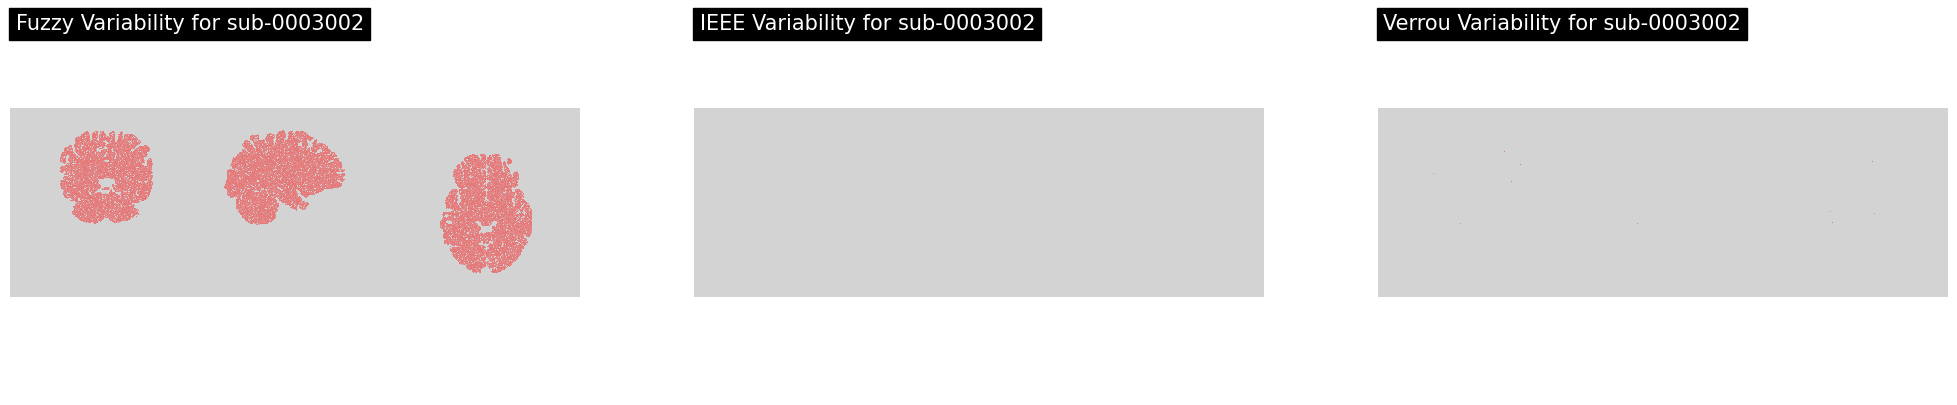

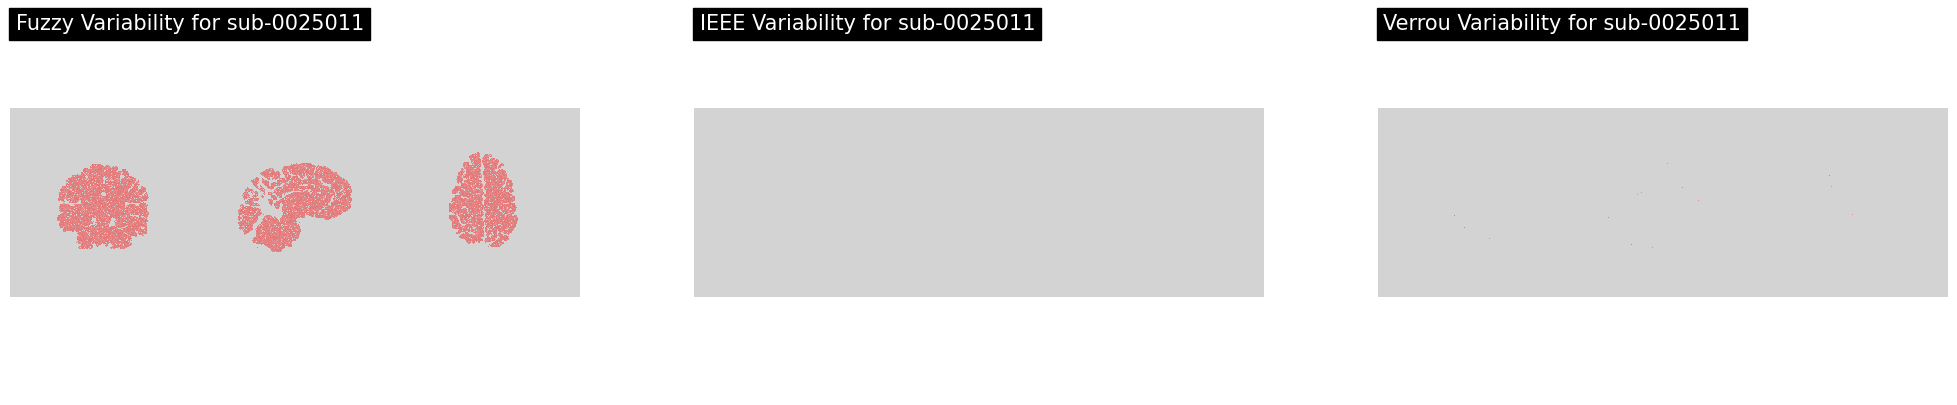

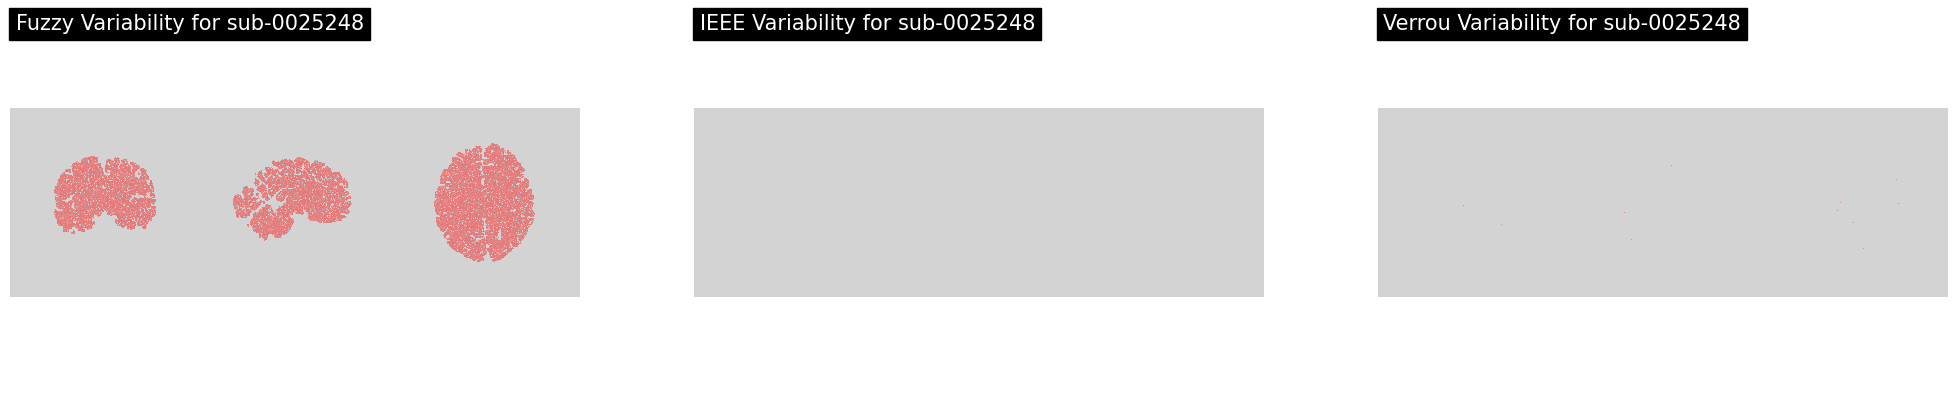

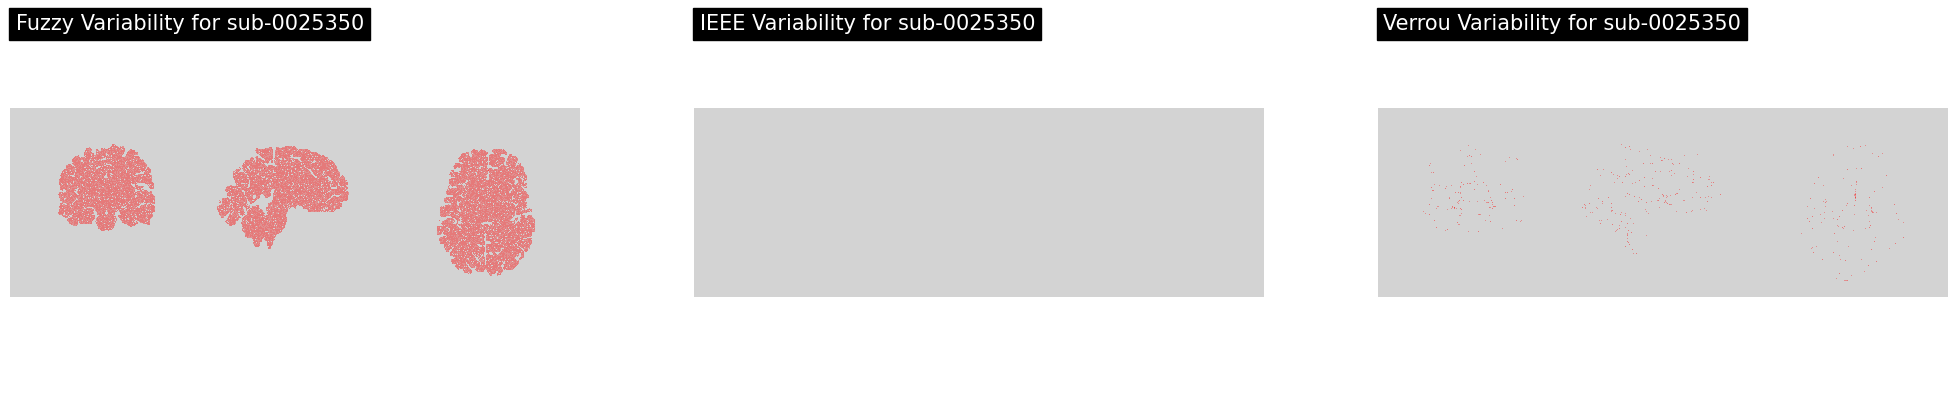

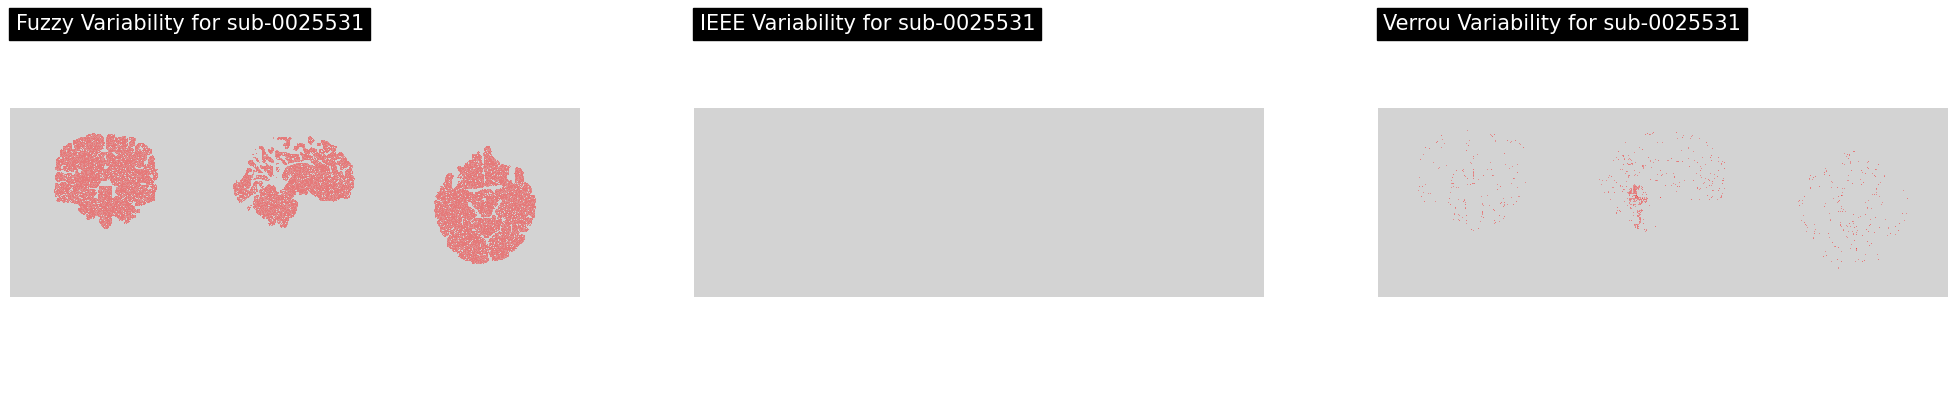

In [3]:
cmap0 = LinearSegmentedColormap.from_list('', ['lightgray', 'red'])
directory = '/home/inesgp/verrou_fastsurfer/'

for subject in ['0003002', '0025011', '0025248', '0025350', '0025531']:
    print(subject)

    fig, axes = plt.subplots(1,3, figsize=(25,5))
    img = nib.load(f"{directory}/sub-{subject}/{subject}_1/mri/aseg.auto_noCCseg.mgz")
    fuzzy_entropy = np.load(f"{directory}/entropy_maps/fuzzy_{subject}.npy")
    ieee_entropy = np.load(f"{directory}/entropy_maps/ieee_{subject}.npy")
    verrou_entropy = np.load(f"{directory}/entropy_maps/verrou_{subject}.npy")

    fuzzy_img = nib.nifti1.Nifti1Image(fuzzy_entropy, img.affine) 
    ieee_img = nib.nifti1.Nifti1Image(ieee_entropy, img.affine) 
    verrou_img = nib.nifti1.Nifti1Image(verrou_entropy, img.affine)

    display = plotting.plot_img(fuzzy_img, cut_coords=(0,0,30), black_bg=False, draw_cross=False, bg_img=None,cmap=cmap0, annotate=False, vmin=0, vmax=1.6, axes=axes[0])
    display.title(f'Fuzzy Variability for sub-{subject}')
    display = plotting.plot_img(ieee_img, cut_coords=(0,0,30), black_bg=False, draw_cross=False, bg_img=None,cmap=cmap0, annotate=False, vmin=0, vmax=1.6, axes=axes[1])
    display.title(f'IEEE Variability for sub-{subject}')
    display = plotting.plot_img(verrou_img, cut_coords=(0,0,30), black_bg=False, draw_cross=False, bg_img=None,cmap=cmap0, annotate=False, vmin=0, vmax=1.6, axes=axes[2])
    display.title(f'Verrou Variability for sub-{subject}')



    # break
